In [1]:
import numpy as np
import scienceplots
from matplotlib import pyplot as plt
import matplotlib as mp
import pandas as pd
import os
import scipy as sp
import seaborn as sns
import json
import yaml
import functools
import itertools

In [2]:
def average_data(df, keep=['cpu', 'client']):
    res = df.groupby(keep+['run']).mean(numeric_only=True).reset_index()
    res = res.groupby(keep).median(numeric_only=True).reset_index()
    return res

def sum_data(df, keep=['cpu', 'client']):
    res = df.groupby(keep+['run']).sum(numeric_only=True).reset_index()
    res = res.groupby(keep).median(numeric_only=True).reset_index()
    return res

def import_throughput(res_dir, skip=None):
    throughput_csv = pd.read_csv(f"../{res_dir}/summary/server/throughput-sar.csv")
    
#     throughput_csv['client'] *= 10
    throughput_csv['rxkB/s'] *= 8e-6
    throughput_csv['txkB/s'] *= 8e-6
#     throughput_csv['rxpck/s'] *= 1e-6
#     throughput_csv['txpck/s'] *= 1e-6
    throughput_csv['expected'] = throughput_csv['client'] * 1

    throughput_wg = throughput_csv[throughput_csv.iface == 'wg']
    throughput_phy = throughput_csv[throughput_csv.iface == 'eno1']    

    net_wg = average_data(throughput_wg)
    net_phy = average_data(throughput_phy)
    
    return net_wg, net_phy

def import_cpu(res_dir, skip=None):
    cpu_csv = pd.read_csv(f"{res_dir}/summary/server/cpu-sar.csv")
    
#     cpu_csv['client'] *= 10
    cpu_csv['used'] = 100 - cpu_csv['idle']

    cpu = average_data(cpu_csv, keep=['cpu', 'client', 'core'])
    
    if skip is not None:
        cpu = cpu[cpu['client'] != skip]
    
    per_core = cpu[cpu.core != -1]
    global_cpu = cpu[cpu.core == -1]
    
    return global_cpu, per_core

def import_decrypt(res_dir, skip=None):
    df = pd.read_csv(f"{res_dir}/summary/decrypt_time.csv")
    
    df = average_data(df, keep=['clients'])
    df = df.reset_index(drop=True)
    
    if skip is not None:
        df = df[df['clients'] != skip]

    cpu, pcpu = import_cpu(res_dir, skip=skip)
    cpu = cpu.reset_index(drop=True)

    df_2 = pd.concat([cpu, df], axis=1)
    df_2.decrypt_packet = df_2.decrypt_packet * df_2.used / 100
    df_2.spin_lock = df_2.spin_lock * df_2.used / 100
    df_2.decrypt_worker = df_2.decrypt_worker * df_2.used / 100

    keep = ['clients', 'decrypt_worker', 'decrypt_packet', 'spin_lock']
    
    return df[keep], df_2[keep]
    
    
def import_iperf(res_dir):
    df_t = []
    for i in range(1, 2):
        try:
            net_client_csv = pd.read_csv(
                f"{res_dir}/summary/clients/throughput-{i}.csv",
            )
            net_df = average_data(net_client_csv, keep=['cpu', 'client', 'node'])
            net_df_sum = net_df.groupby(['cpu', 'client']).sum().reset_index()
            net_df_avg = net_df.groupby(['cpu', 'client']).median().reset_index()
            net_df_sum['throughput'] *= 1e-3
            net_df_sum['node'] = i
            df_t.append(net_df_sum)
        except:
            continue
    df = pd.concat(df_t, axis=0)
    
    df = df.groupby(['cpu', 'client']).sum().reset_index()
    
    return df

def import_latency(res_dir, skip=None):
    df_t = []
    for i in range(1, 11):
        try:
            latency_csv = pd.read_csv(
                f"{res_dir}/summary/clients/latency-{i}.csv",
                names=['cpu', 'client', 'node', 'run', 'min', 'mean', 'median', '90th', '99th', 'max', 'std'],
                skiprows=1
            )
        except:
            continue
        latency_df = average_data(latency_csv, keep=['cpu', 'client'])
#         latency_df['client'] *= 10
        latency_df[['mean', 'median', '90th', '99th', 'max', 'std']] *= 1e-3
        latency_df['node'] = i
        df_t.append(latency_df)
    df = pd.concat(df_t, axis=0)
    
    latency_df = df.groupby(['cpu', 'client']).median().reset_index()
    
    if skip is not None:
        if not isinstance(skip, list):
            skip = [skip]
        latency_df = latency_df[~latency_df.client.isin(skip)]
    
    return latency_df

In [3]:
def infos_resdir(resdir):
    t = f"{maindir}/{resdir}"
    curr_dir_f = f"{t}/EXPERIMENT_DATA/CURRENT_EXP"
    
    with open(curr_dir_f) as f:
        curr_dir = f.readlines()[0].strip()
        name = curr_dir.split("-")[2]
    return {
        'test': curr_dir,
        'path': t,
        'name': name
    }
def find_index(res_dirs, val):
    for k, res in enumerate(res_dirs):
        if res['name'] == val:
            return k

In [4]:
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 15

In [5]:
skip = 1
names = ['VANILLA', 'CRYPTONCE']
naming = {
    'yes': 'VANILLA',
    'partial': "CRYPTONCE"
}
naming_2 = {
    'yes': 'VANILLA-v2',
    'partial': "CRYPTONCE-v2"
}
names_2 = ["VANILLA-v2", "CRYPTONCE-v2"]
ms = ['x', 'o', 's']
colors = ['black', 'red']

In [26]:
def compute_improvement(res_dirs, importer, metric, index='client', names=[]):
    base = res_dirs[0]
    other = res_dirs[1]
    
    df_base = importer(base['path']).reset_index(drop=True)
    df_base = df_base[df_base[index] != skip]
    df_base = df_base.set_index(index)

    df_other = importer(other['path']).reset_index(drop=True)
    df_other = df_other[df_other[index] != skip]
    df_other = df_other.set_index(index)
    impr = (- df_other + df_base) * 100 / df_base
    diff = (- df_other + df_base)
    

    clients = list(diff.index)
    data_impr = list(impr[metric])
    data_diff = list(diff[metric])
    data = {
        'client': clients,
        'improvement': data_impr,
        'difference': data_diff,
    }

    out = pd.DataFrame(data).set_index('client')

    for name, res_dir in zip(names, res_dirs):
        df = importer(res_dir['path'])
        df = df[df[index] != skip].set_index(index)
        out[name] = df[metric]
    
    return out

def import_decrypt_absolute(res_dir, skip=None):
    return import_decrypt(res_dir, skip=skip)[1]

def import_decrypt_relative(res_dir, skip=None):
    return import_decrypt(res_dir, skip=skip)[0]

def plot_improvement(out, savefig=None, ylabel='CPU Usage (in \%)', ylim=[0, 1], figsize=(8, 5),
                     space=1, names=names, annotate="improvement", colors=colors, n_cols=1,
                     legend_size=11, columnspacing=1.5, width=.8, fontsize=12, ticker=5):
    with plt.style.context(['science', 'ieee']):
        ax = out[names].plot.bar(
            ylim=ylim, figsize=figsize,
            xlabel='Clients', ylabel=ylabel,
            grid=True, color=colors, width=width,
        )

        if annotate is not None:
            for k, i in enumerate(out.index):
                max_height = max([out.loc[i, name] for name in names])  # Position at the higher bar
                ax.text(k, max_height + space, f'{out.loc[i, annotate]:.2f}\%', 
                        ha='center', fontsize=fontsize)

        plt.xticks(rotation=0)
        ax.yaxis.set_major_locator(mp.ticker.MultipleLocator(ticker))
        plt.legend(loc='upper left', prop = {"size":legend_size}, ncol=n_cols, columnspacing=1.5)
        if savefig is not None:
            plt.savefig(savefig, dpi=300)

In [27]:
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)

In [28]:
def print_tab(t):
    for i in t:
        print(i)

In [50]:
dir_ = "res"
skip = None
maindir = f"../{dir_}"
res_dirs = [infos_resdir(f) for f in os.listdir(maindir)]
# index = find_index(res_dirs, 'no')
# res_dirs.pop(index)
index = find_index(res_dirs, 'yes')
yes = res_dirs.pop(index)
res_dirs.insert(0, yes)
try:
    os.makedirs(f"../graphs/{dir_}")
except:
    pass
print_tab(enumerate(res_dirs))
res_dirs = [res_dirs[0], res_dirs[5]]
print()
print_tab(enumerate(res_dirs))

(0, {'test': 'upload--yes-kernel-v1', 'path': '../res/results-5bf7322e', 'name': 'yes'})
(1, {'test': 'upload--partial-kernel-v3', 'path': '../res/results-bcf87c30', 'name': 'partial'})
(2, {'test': 'upload--partial-kernel-v3-bp', 'path': '../res/results-10af234a', 'name': 'partial'})
(3, {'test': 'upload--partial-kernel-v1', 'path': '../res/results-3a8a6d32', 'name': 'partial'})
(4, {'test': 'upload--partial-kernel-v1-check-port', 'path': '../res/results-729a4dc0', 'name': 'partial'})
(5, {'test': 'upload--yes-kernel-v3', 'path': '../res/results-44a5170c', 'name': 'yes'})
(6, {'test': 'upload--yes-kernel-v3-bp', 'path': '../res/results-f6cbf2f9', 'name': 'yes'})

(0, {'test': 'upload--yes-kernel-v1', 'path': '../res/results-5bf7322e', 'name': 'yes'})
(1, {'test': 'upload--yes-kernel-v3', 'path': '../res/results-44a5170c', 'name': 'yes'})


        improvement  difference   VANILLA  CRYPTONCE
client                                              
1         44.744678    0.004951  0.011066   0.006115
10        20.499380    0.024389  0.118973   0.094584
20        11.808250    0.026268  0.222457   0.196189
30        30.271959    0.139255  0.460013   0.320758
40        36.463870    0.281634  0.772364   0.490730
50        48.860290    0.597796  1.223481   0.625685
60        52.706343    0.911237  1.728895   0.817657
70        56.644149    1.203220  2.124173   0.920953
80        58.967265    1.517329  2.573172   1.055843
90        62.147166    1.792591  2.884429   1.091838
100       60.809015    1.785174  2.935706   1.150532


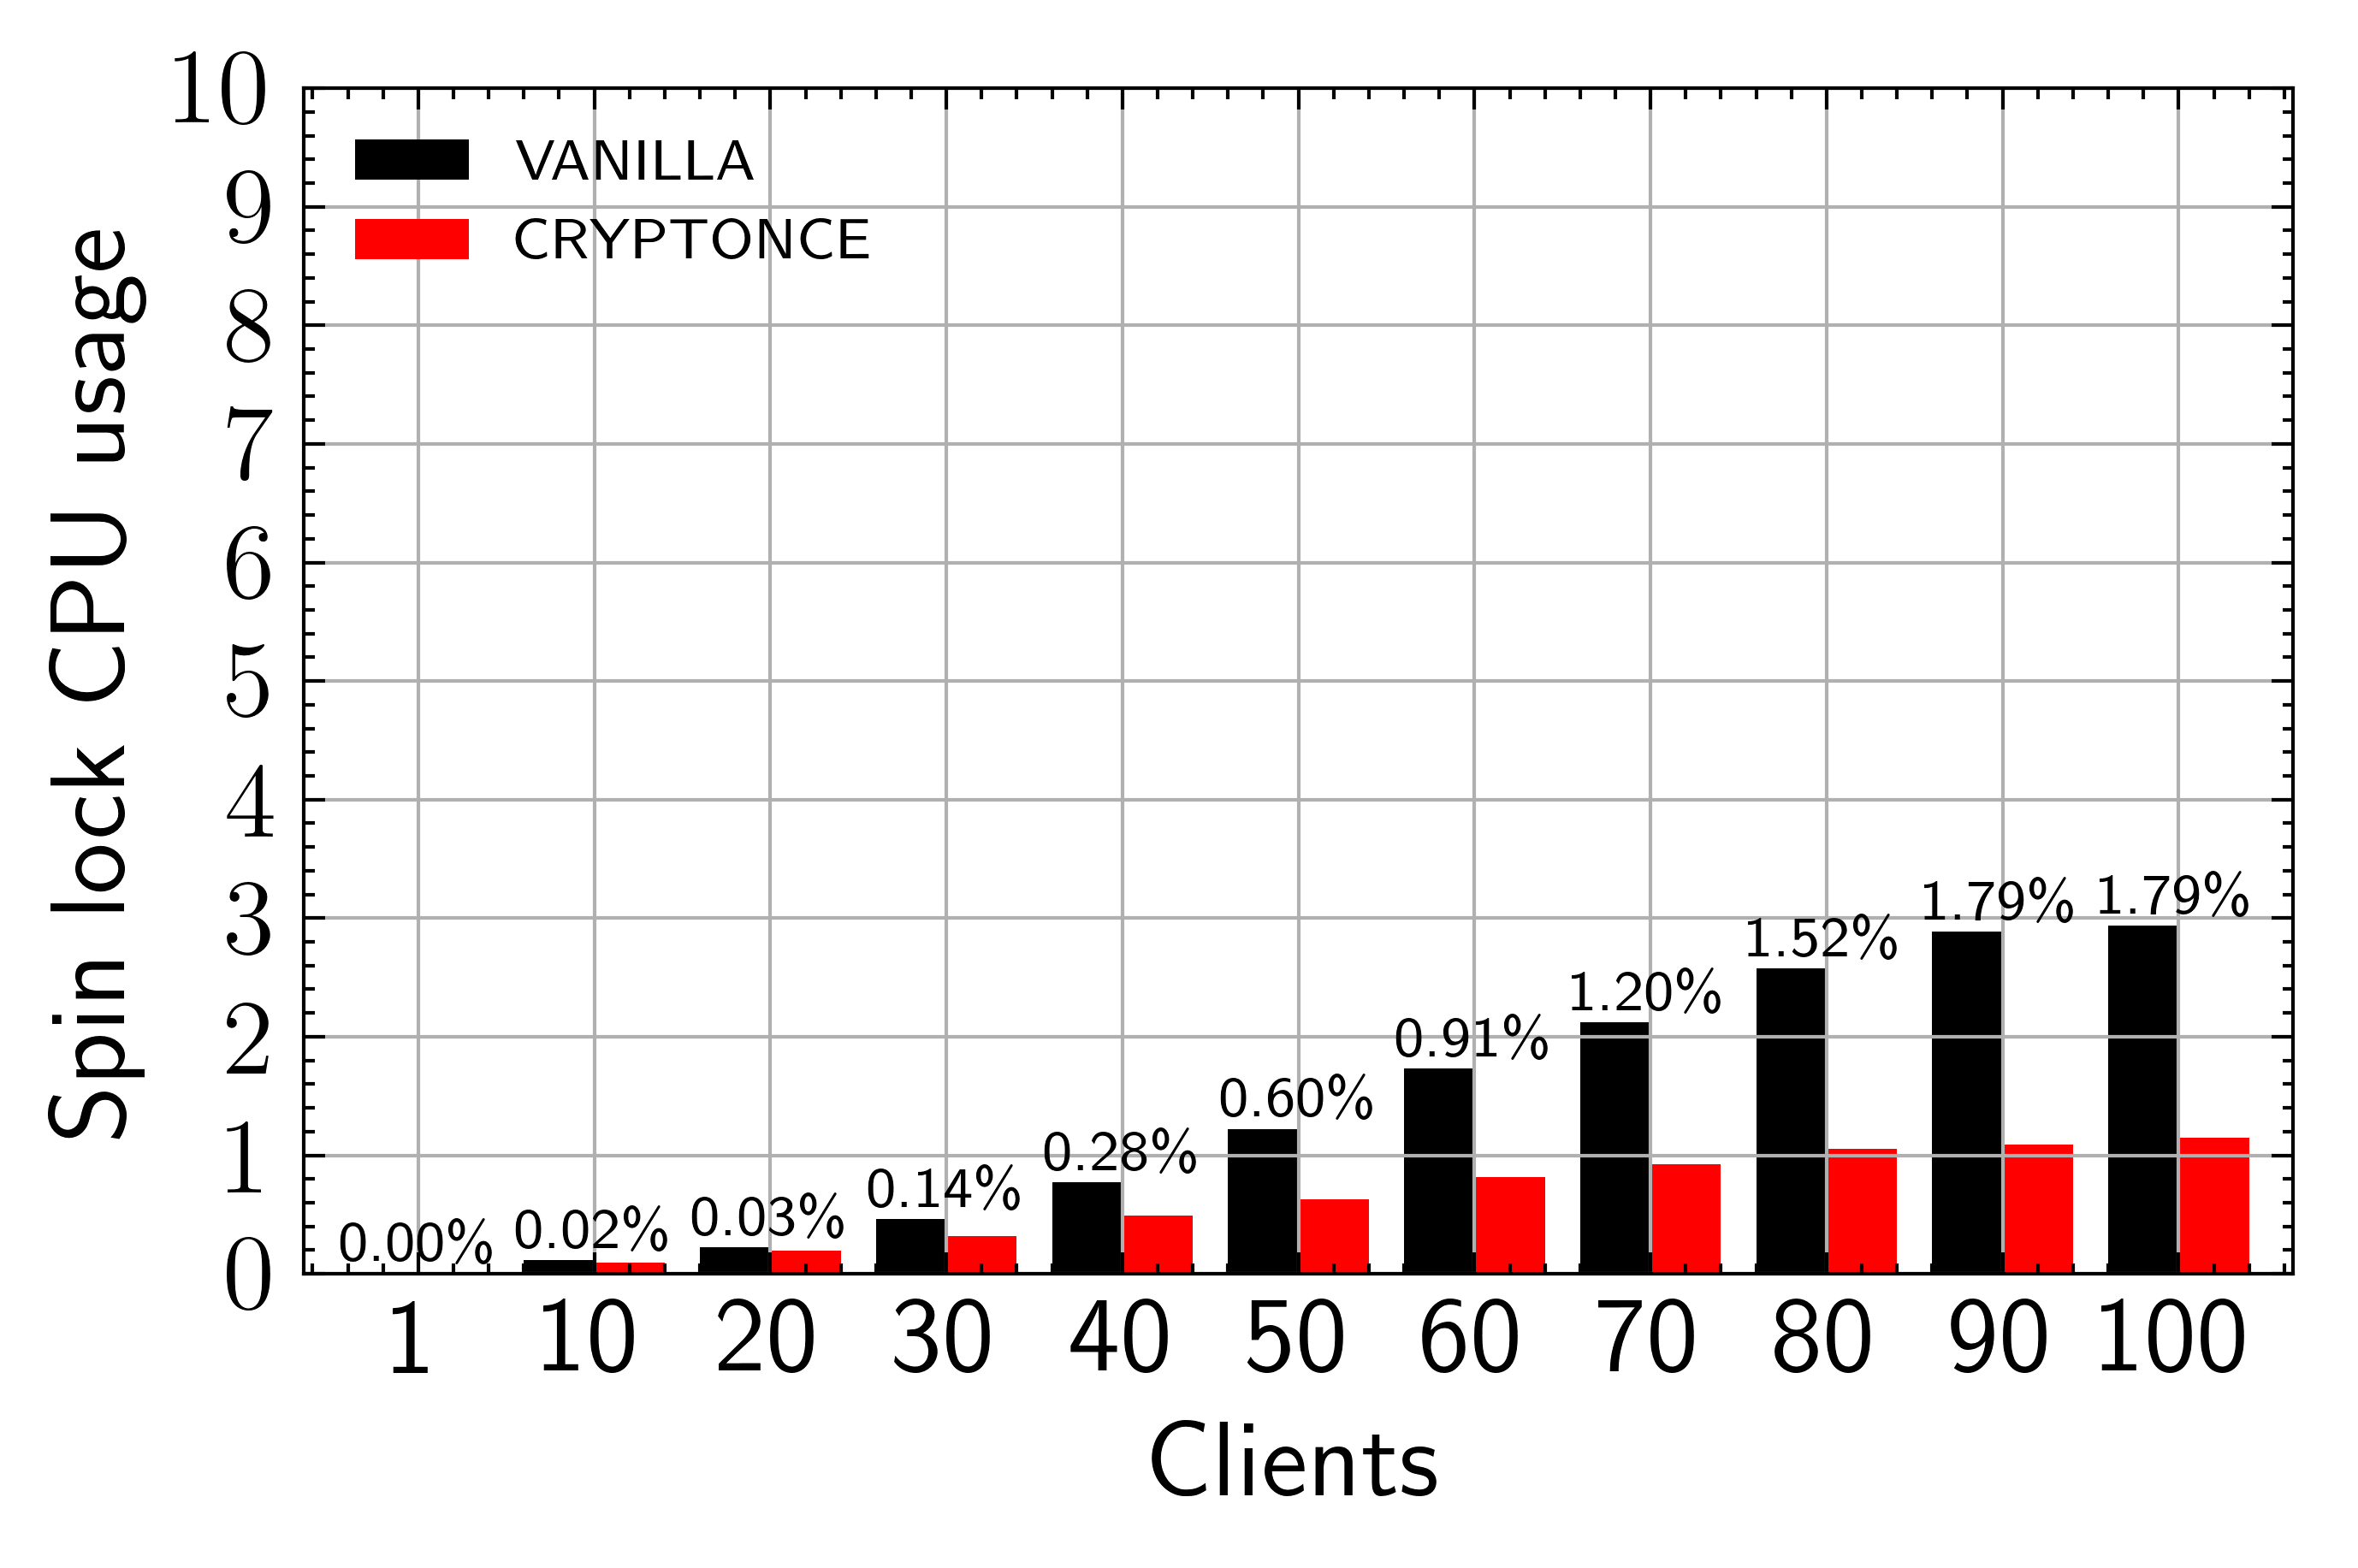

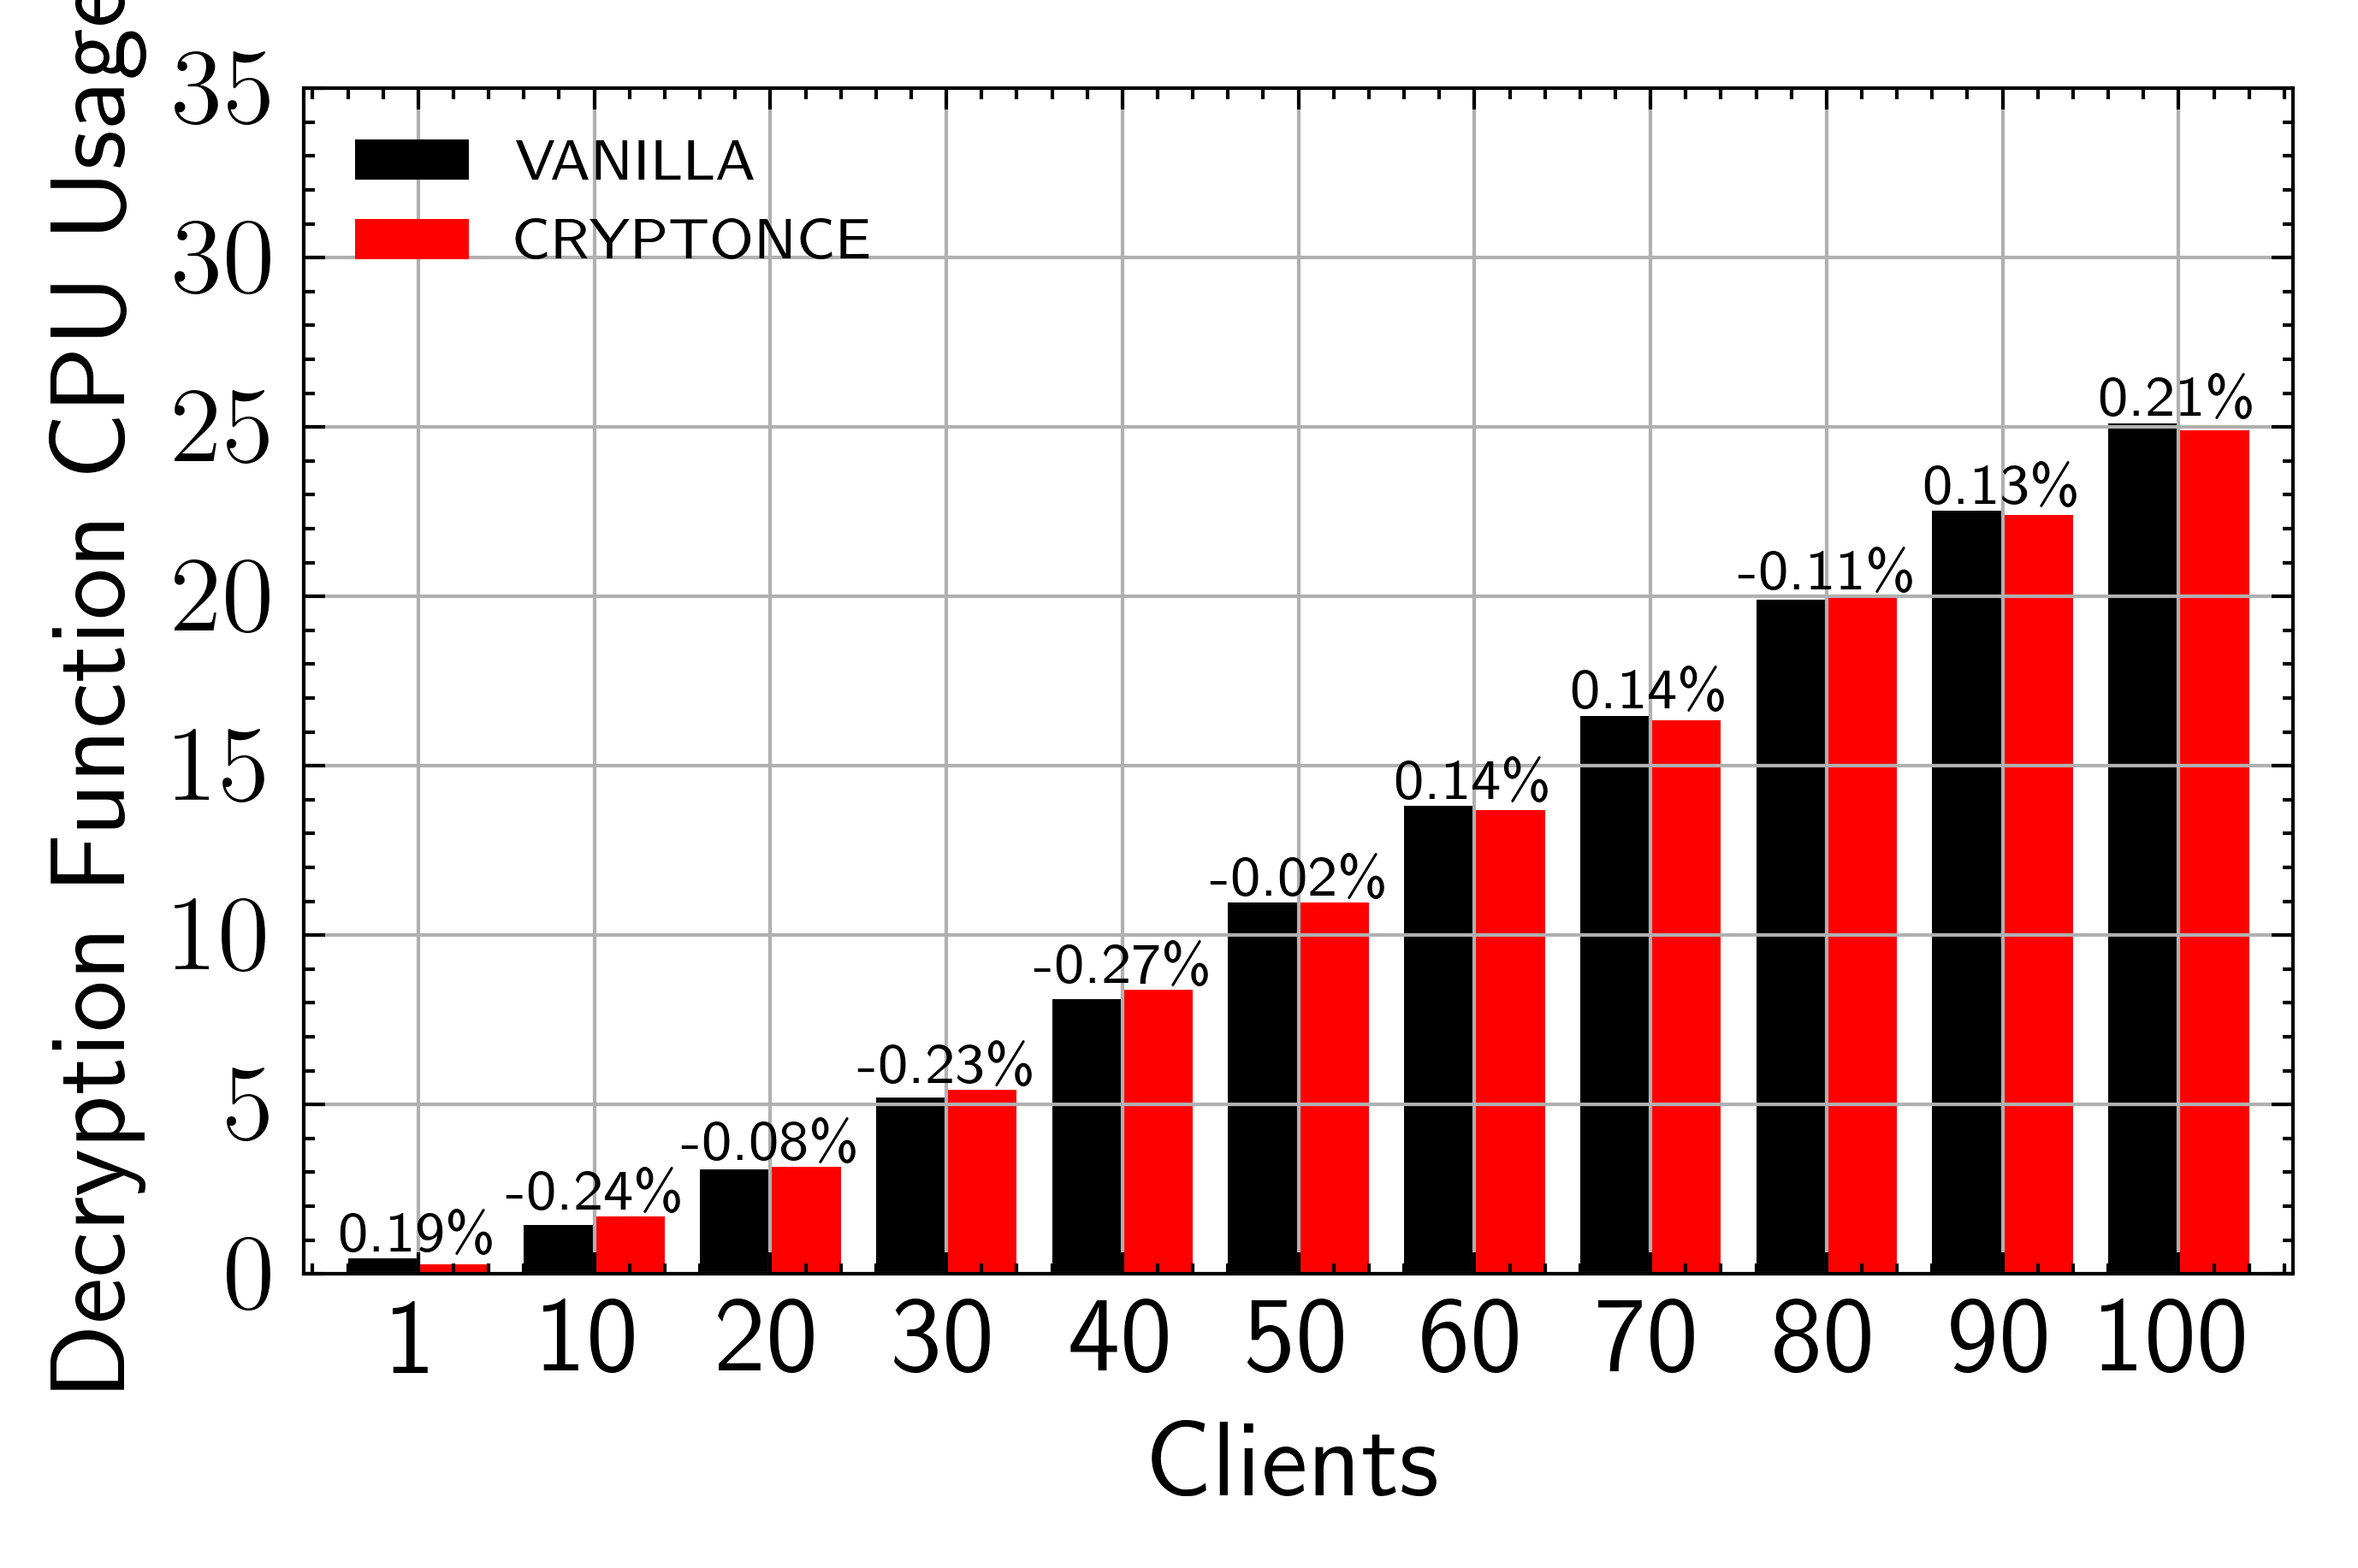

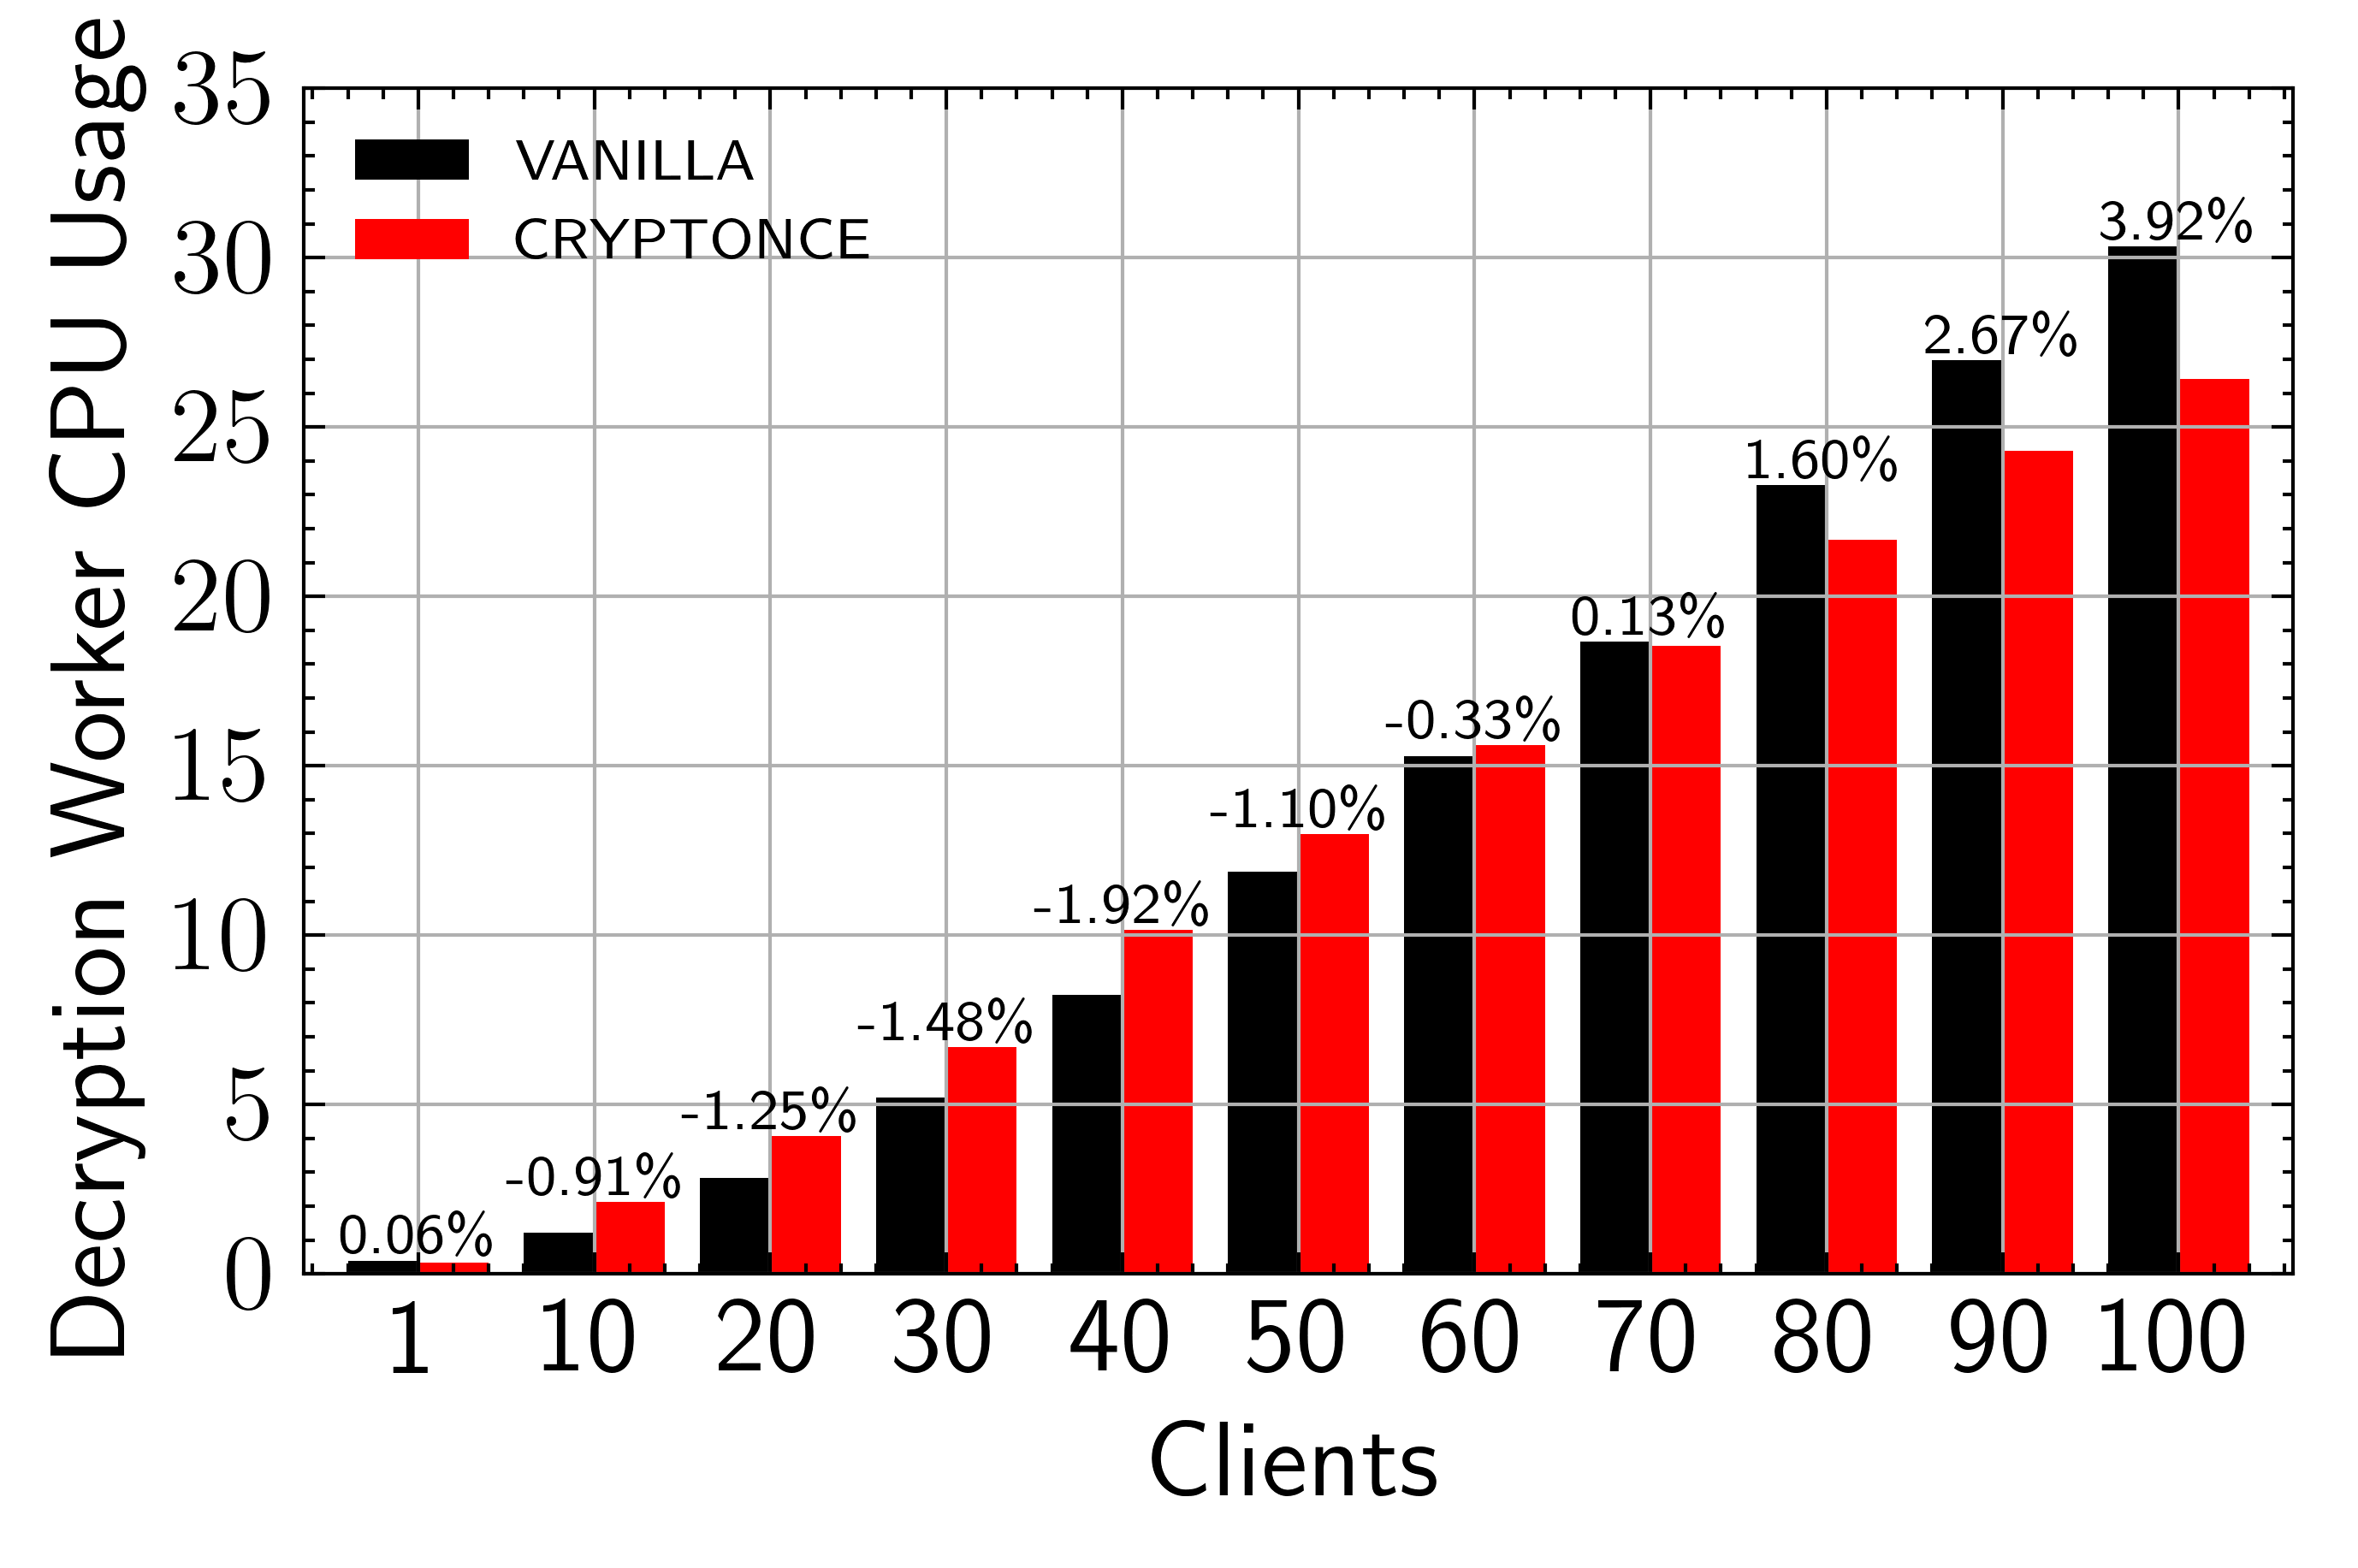

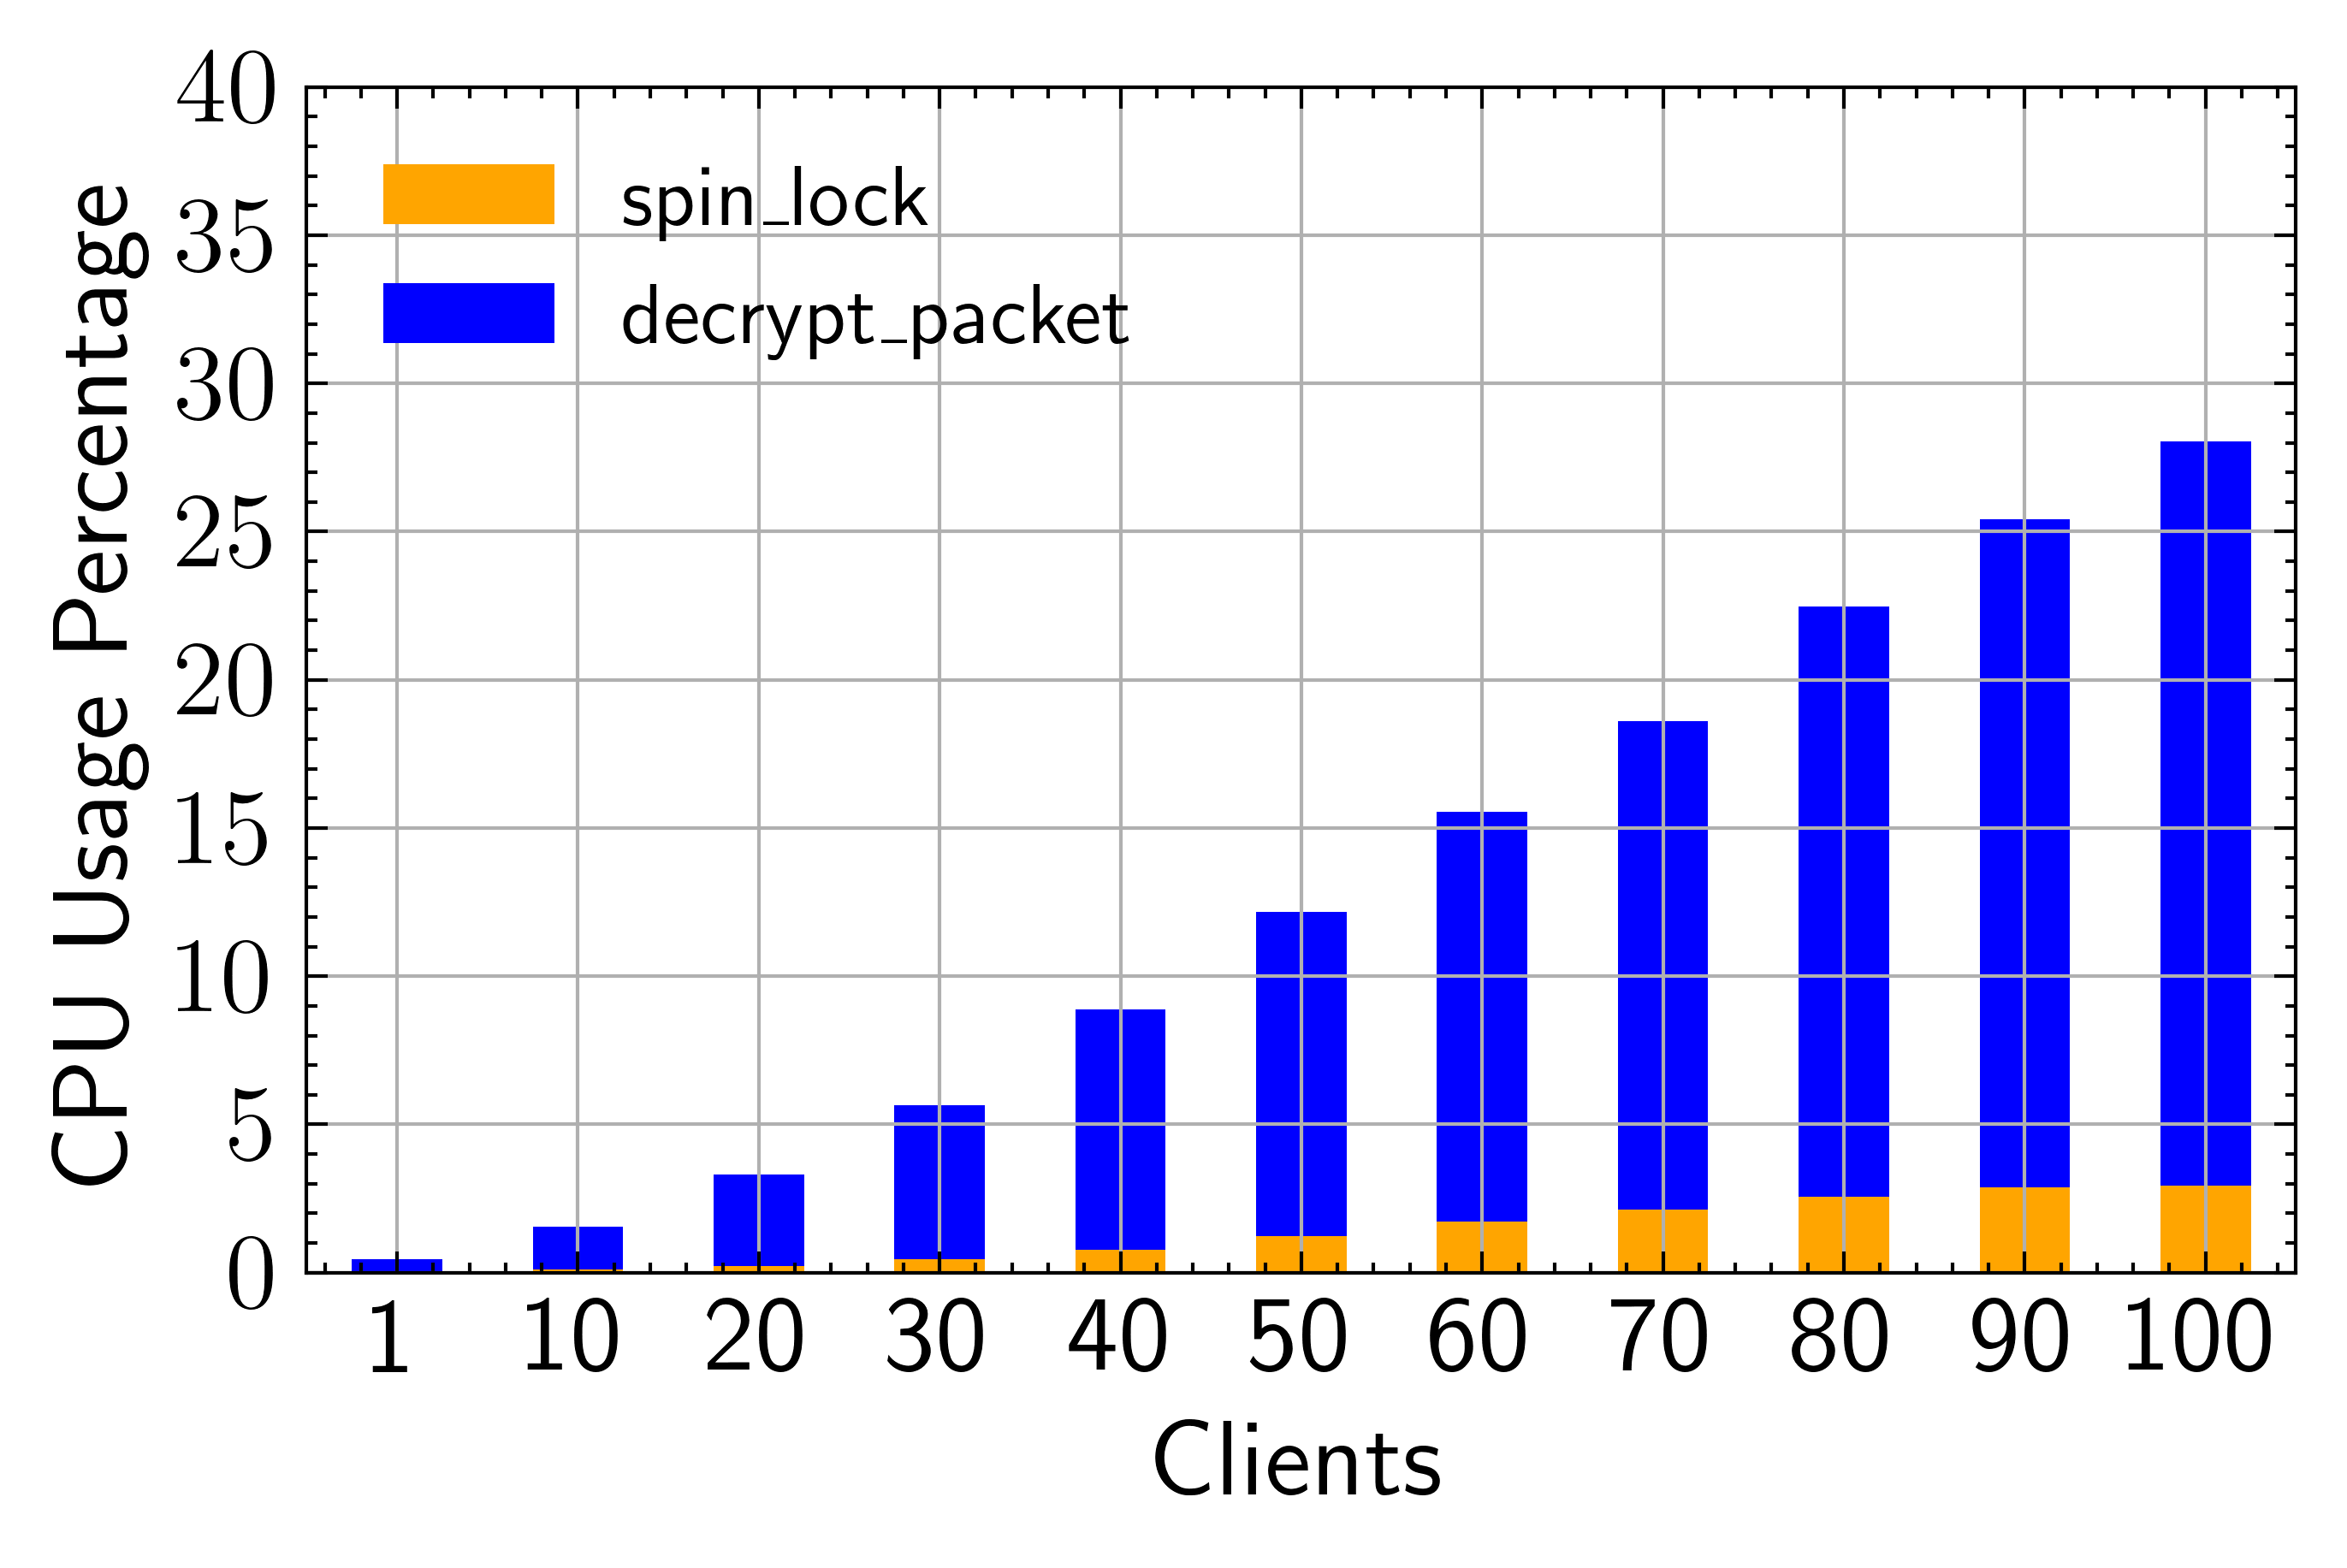

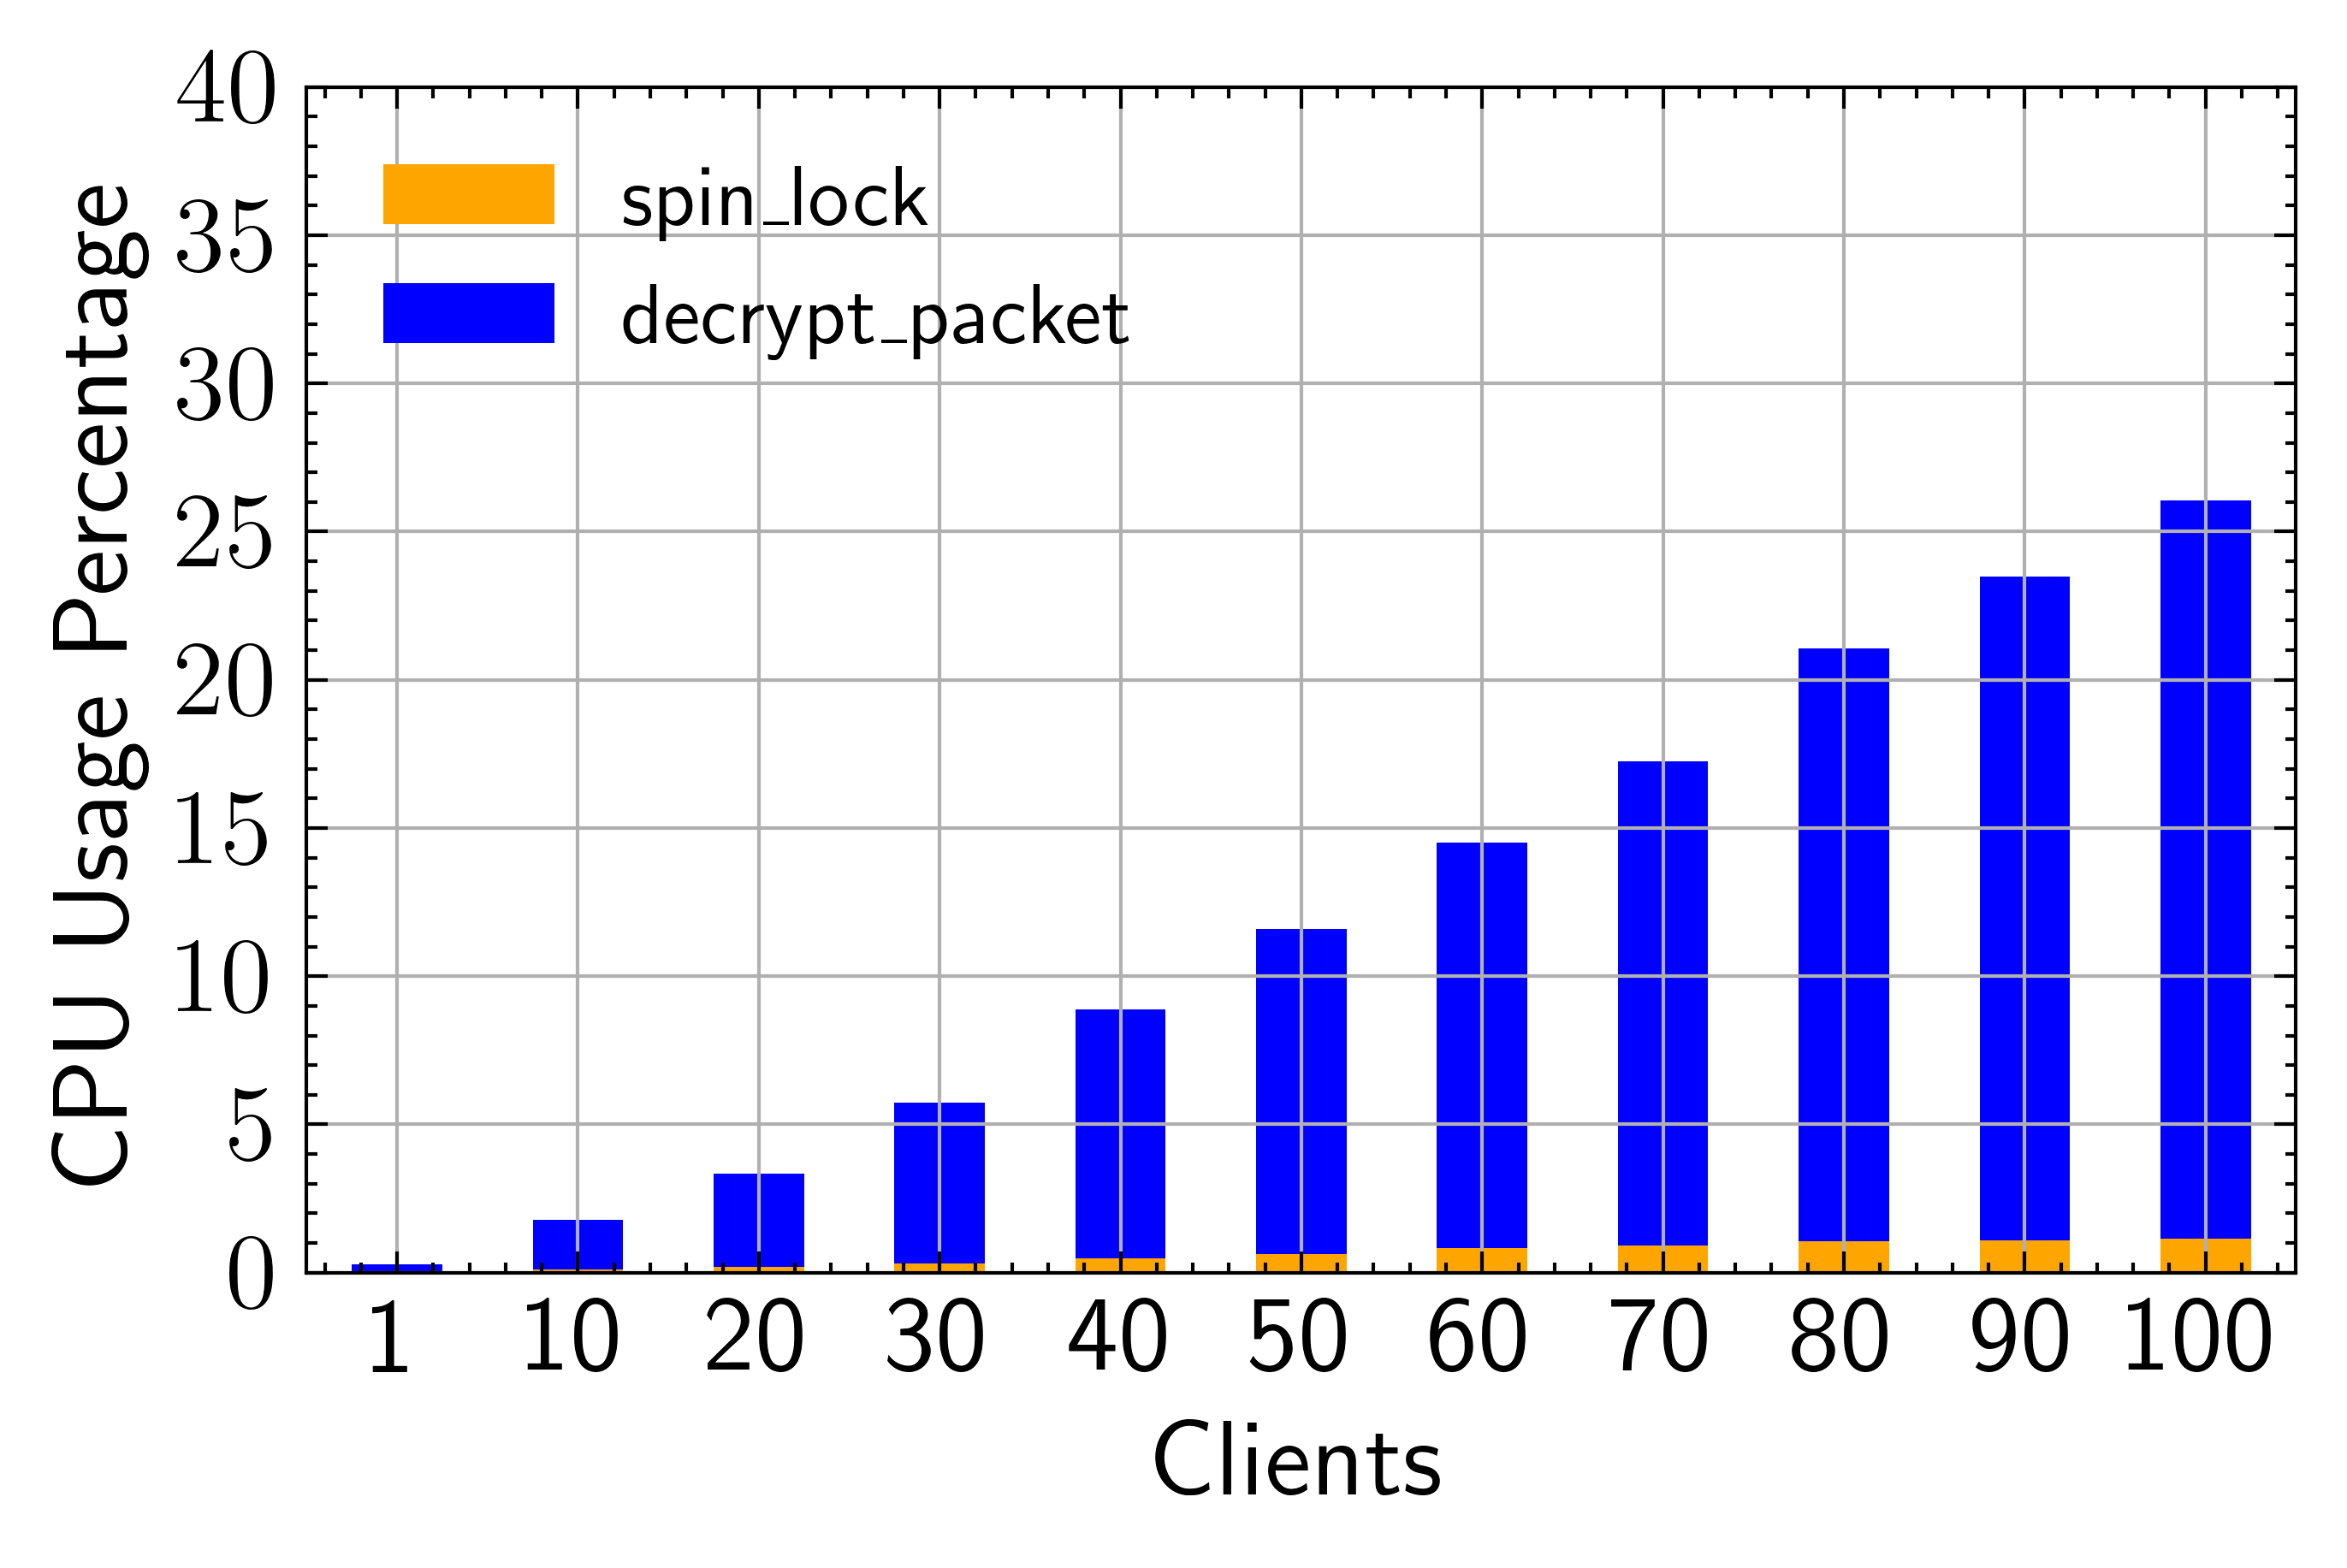

In [51]:
colors = ['black', 'red']
names=['VANILLA', 'CRYPTONCE']
out = compute_improvement(res_dirs, import_decrypt_absolute, 'spin_lock', index='clients', names=names)
plot_improvement(out, ylabel="Spin lock CPU usage", annotate='difference', names=names,
                 ylim=[0, 10], space=.1, colors=colors, n_cols=1, legend_size=8, 
#                  savefig=f"../graphs/{dir_}/decryption_cpu.pdf", 
                 fontsize=8, ticker=1,
                 figsize=(5, 3),
)
print(out)

out = compute_improvement(res_dirs, import_decrypt_absolute, 'decrypt_packet', index='clients', names=names)
plot_improvement(out, ylabel="Decryption Function CPU Usage", annotate='difference', names=names,
                 ylim=[0, 35], space=.2, colors=colors, n_cols=1, legend_size=8, 
#                  savefig=f"../graphs/{dir_}/decryption_cpu.pdf", 
                 fontsize=8,
                 figsize=(5, 3),
)

out = compute_improvement(res_dirs, import_decrypt_absolute, 'decrypt_worker', index='clients', names=names)
plot_improvement(out, ylabel="Decryption Worker CPU Usage", annotate='difference', names=names,
                 ylim=[0, 35], space=.2, colors=colors, n_cols=1, legend_size=8, 
#                  savefig=f"../graphs/{dir_}/decryption_cpu.pdf", 
                 fontsize=8,
                 figsize=(5, 3),
)

cols = ['spin_lock', 'decrypt_packet']
colors = ['orange', 'blue']

for res in res_dirs:
    df = import_decrypt(res['path'])[1].set_index('clients')
    with plt.style.context(['science', 'ieee']):
        ax = df[cols].plot.bar(figsize=(5, 3),
            xlabel="Clients", ylabel="CPU Usage Percentage",
            stacked=True, ylim=[0, 40], color=colors, grid=True,
        )

        plt.xticks(rotation=0)
        plt.legend(loc='upper left', prop = {"size":12})
        ax.yaxis.set_major_locator(mp.ticker.MultipleLocator(5))
        plt.savefig(f"../graphs/{dir_}/spinratios_{res['name']}.pdf", dpi=300)


In [42]:
dir_ = "upload-res-v3-10NP"
skip = 1
maindir = f"../{dir_}"
res_dirs = [infos_resdir(f) for f in os.listdir(maindir)]
# index = find_index(res_dirs, 'no')
# res_dirs.pop(index)
index = find_index(res_dirs, 'yes')
yes = res_dirs.pop(index)
res_dirs.insert(0, yes)
try:
    os.makedirs(f"../graphs/{dir_}")
except:
    pass
print_tab(enumerate(res_dirs))
res_dirs = [res_dirs[0], res_dirs[1]]
print()
print_tab(enumerate(res_dirs))

(0, {'test': 'upload--yes-kernel-v1', 'path': '../upload-res-v3-10NP/results-1dd62a44', 'name': 'yes'})
(1, {'test': 'upload--yes-kernel-v3', 'path': '../upload-res-v3-10NP/results-6864a0c9', 'name': 'yes'})
(2, {'test': 'upload--partial-kernel-v3', 'path': '../upload-res-v3-10NP/results-3cb43eaa', 'name': 'partial'})
(3, {'test': 'upload--partial-kernel-v1', 'path': '../upload-res-v3-10NP/results-cf488459', 'name': 'partial'})

(0, {'test': 'upload--yes-kernel-v1', 'path': '../upload-res-v3-10NP/results-1dd62a44', 'name': 'yes'})
(1, {'test': 'upload--yes-kernel-v3', 'path': '../upload-res-v3-10NP/results-6864a0c9', 'name': 'yes'})


        improvement  difference   VANILLA  CRYPTONCE-B10
client                                                  
10        49.933134    0.050780  0.101696       0.050916
20        61.726472    0.131378  0.212840       0.081461
30        69.293831    0.350074  0.505202       0.155128
40        74.793265    0.699786  0.935627       0.235841
50        71.870304    0.930727  1.295009       0.364282
60        75.743192    1.240591  1.637891       0.397300
70        76.081643    1.544532  2.030098       0.485566
80        74.750020    1.778698  2.379528       0.600830
90        73.858987    1.975178  2.674256       0.699078
100       71.315379    1.992909  2.794501       0.801592


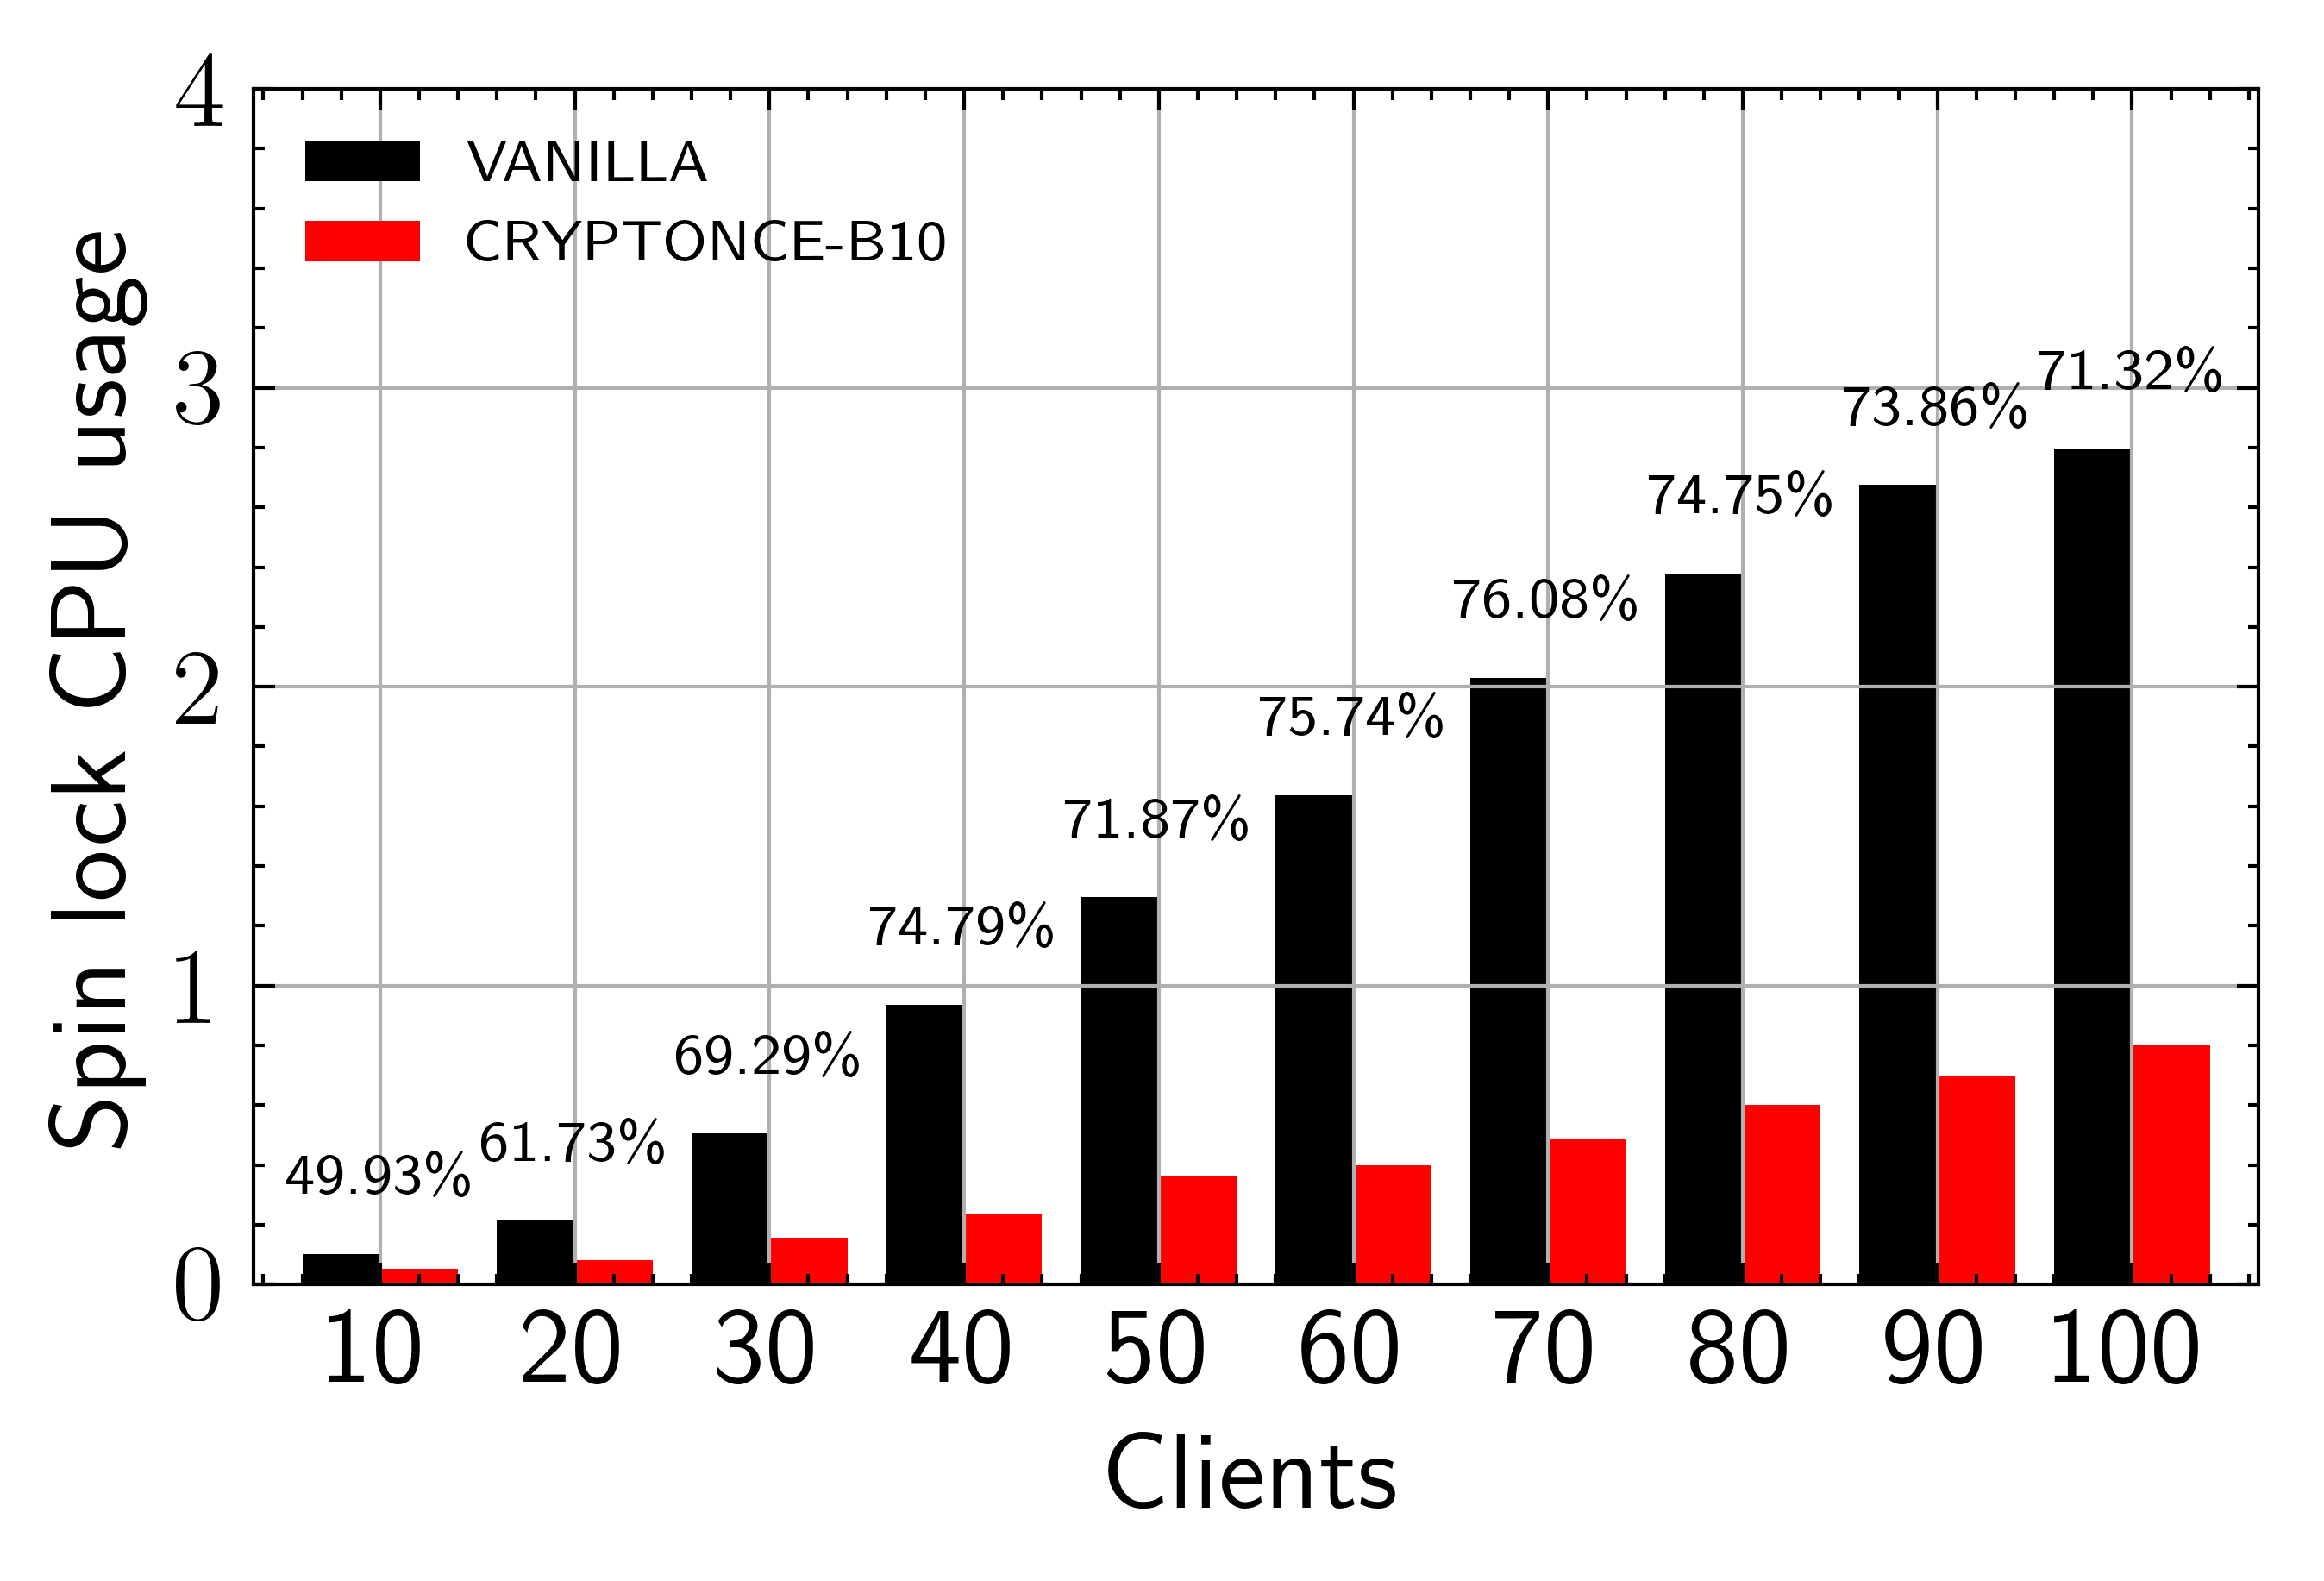

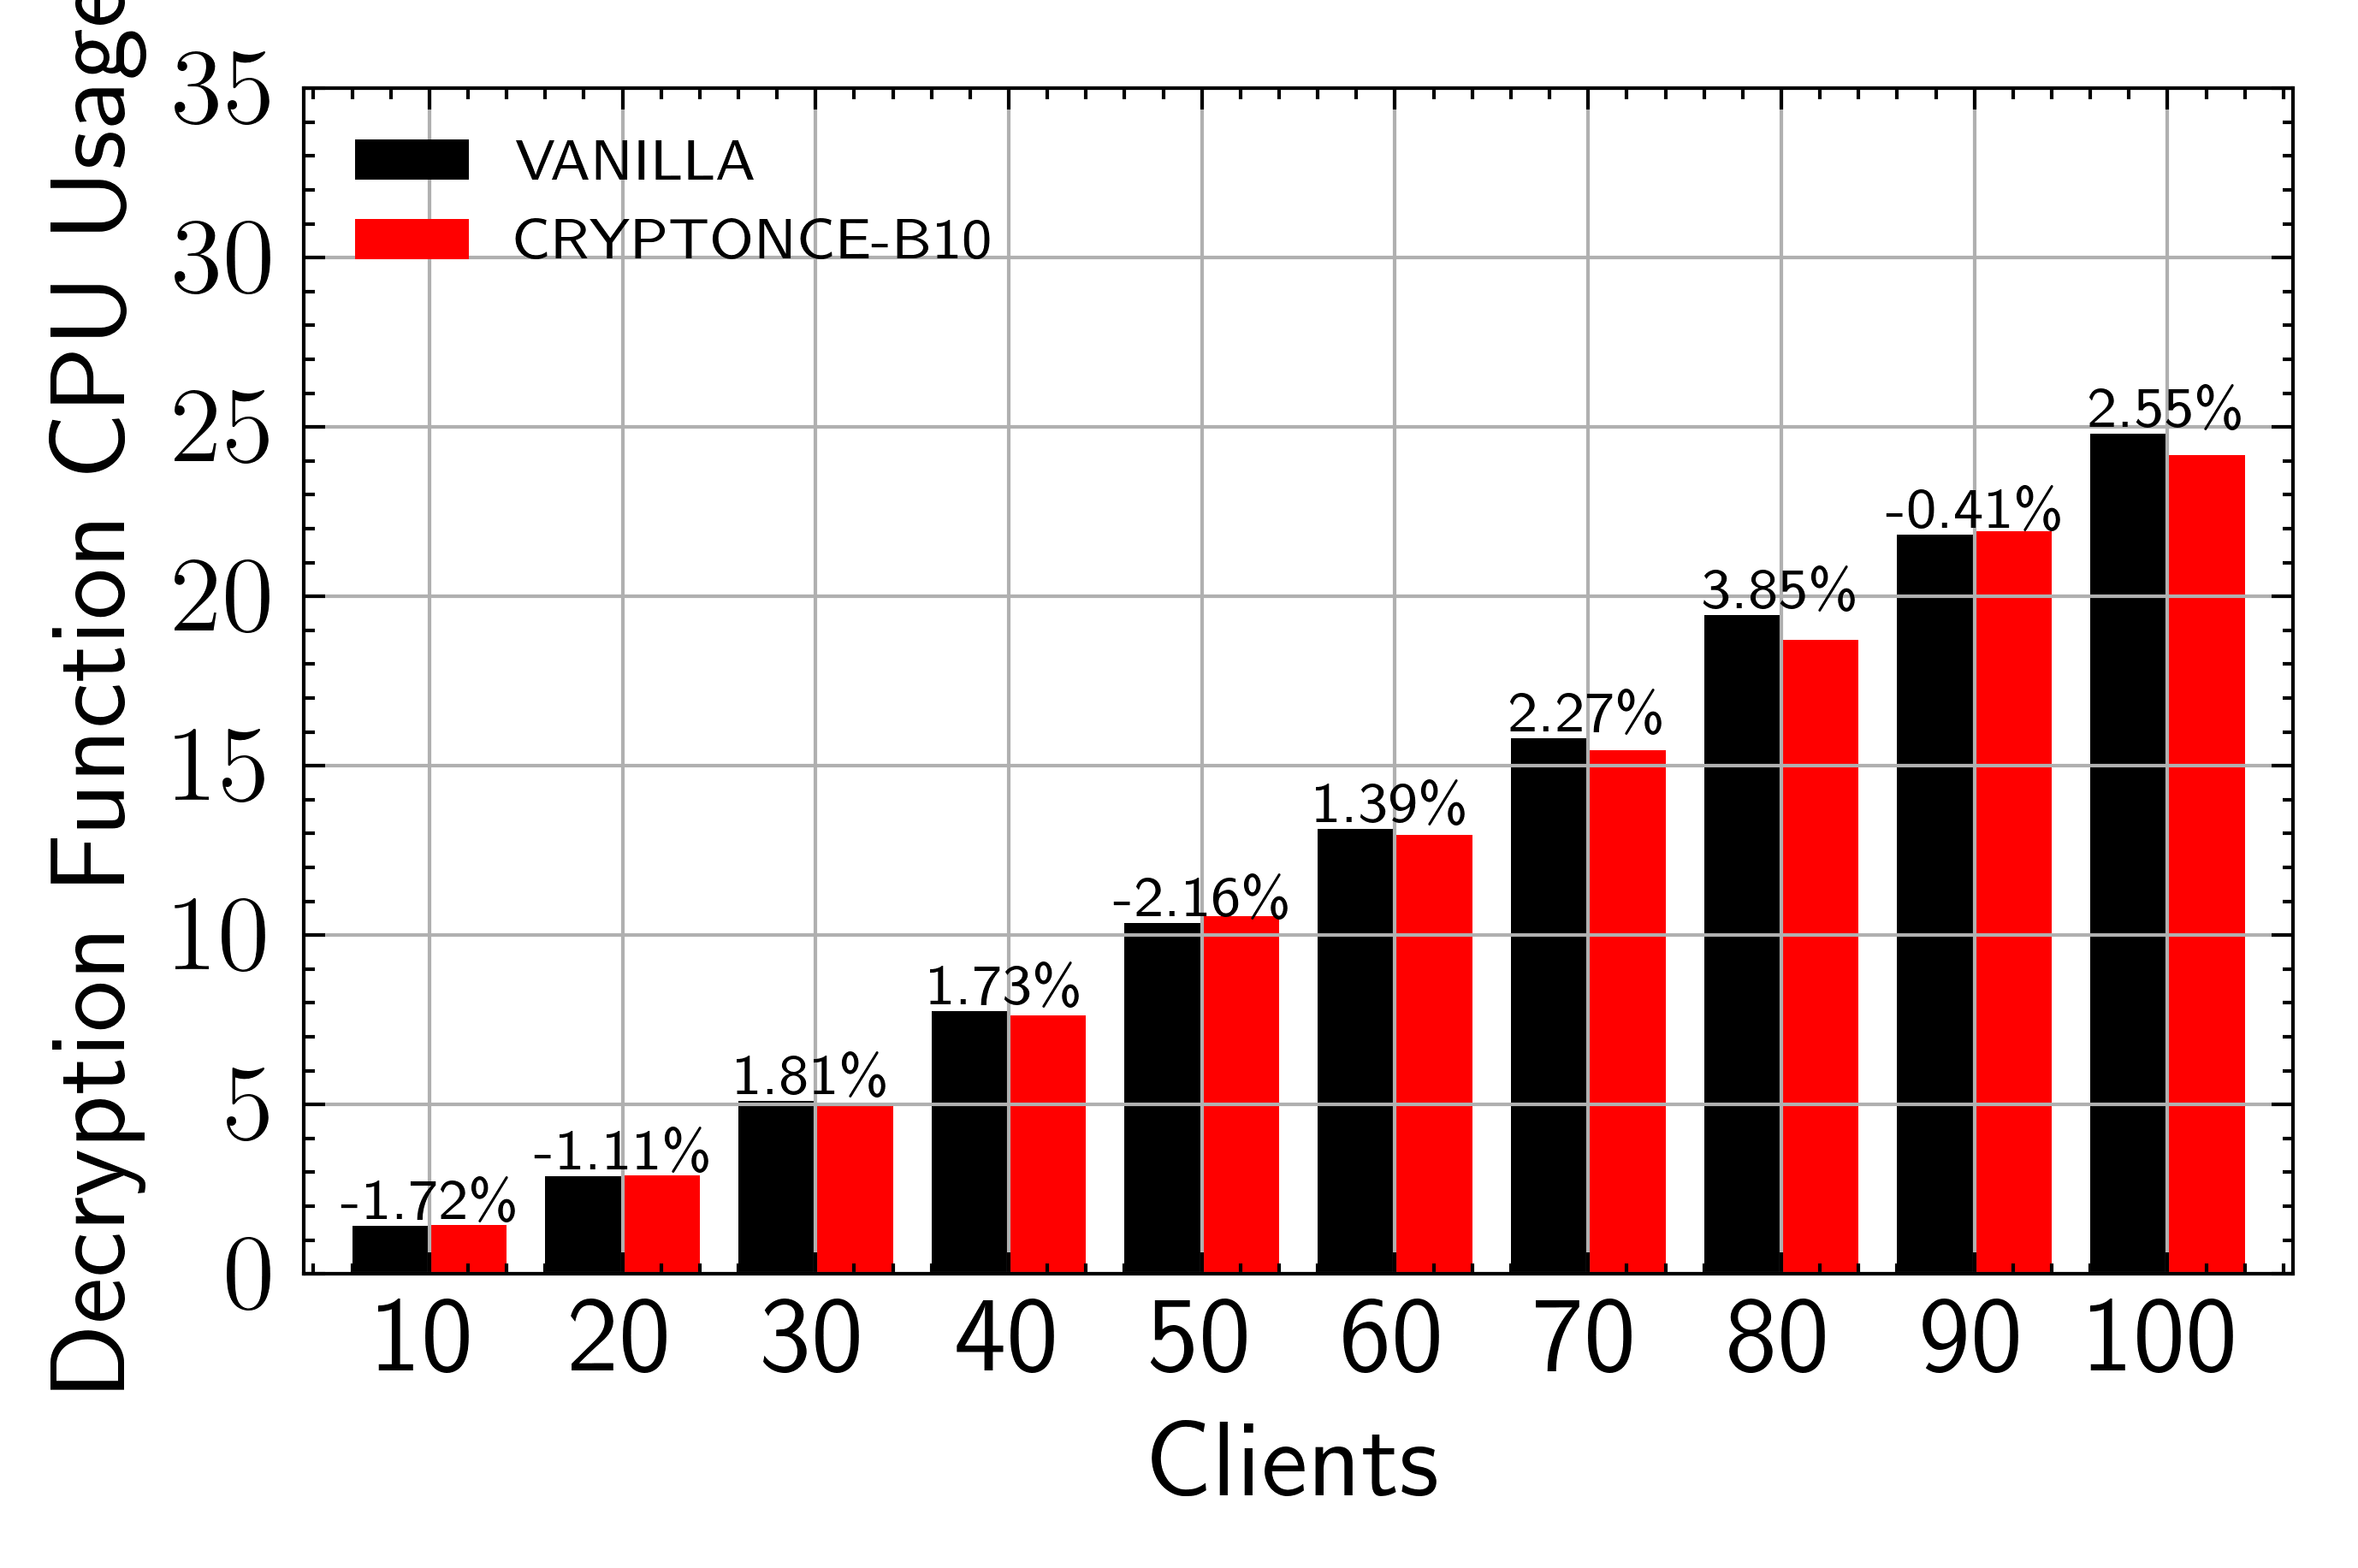

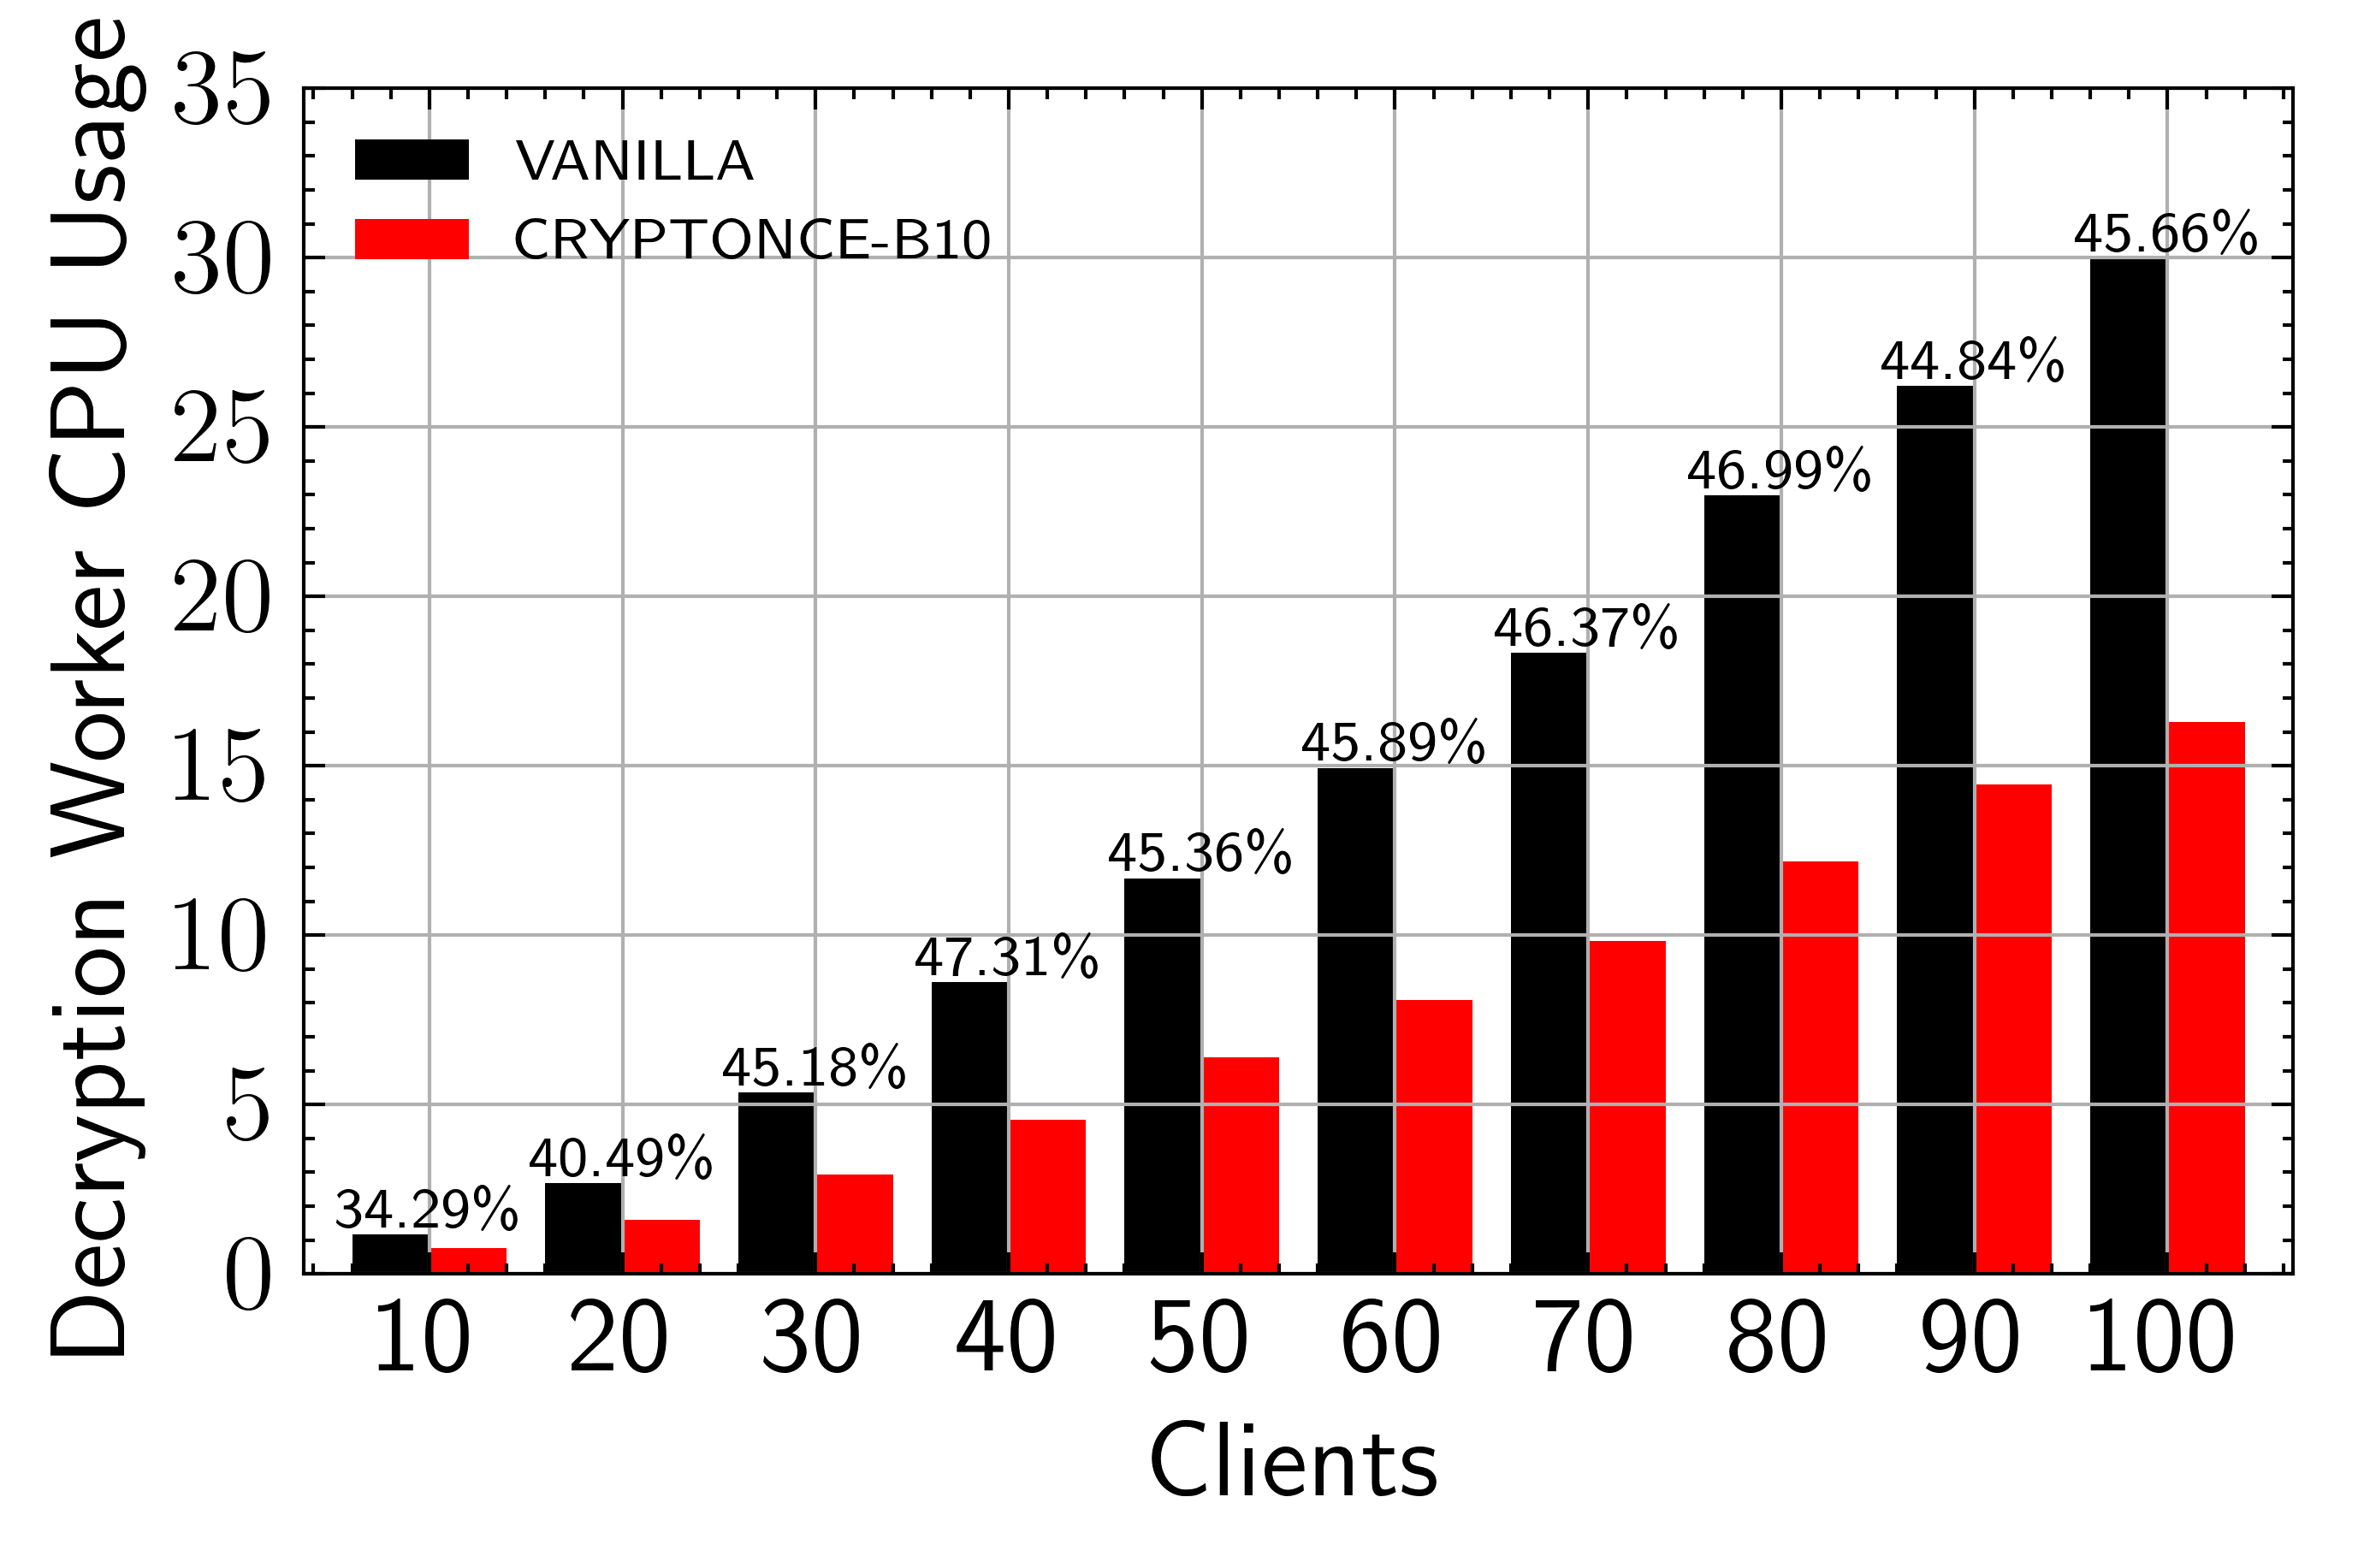

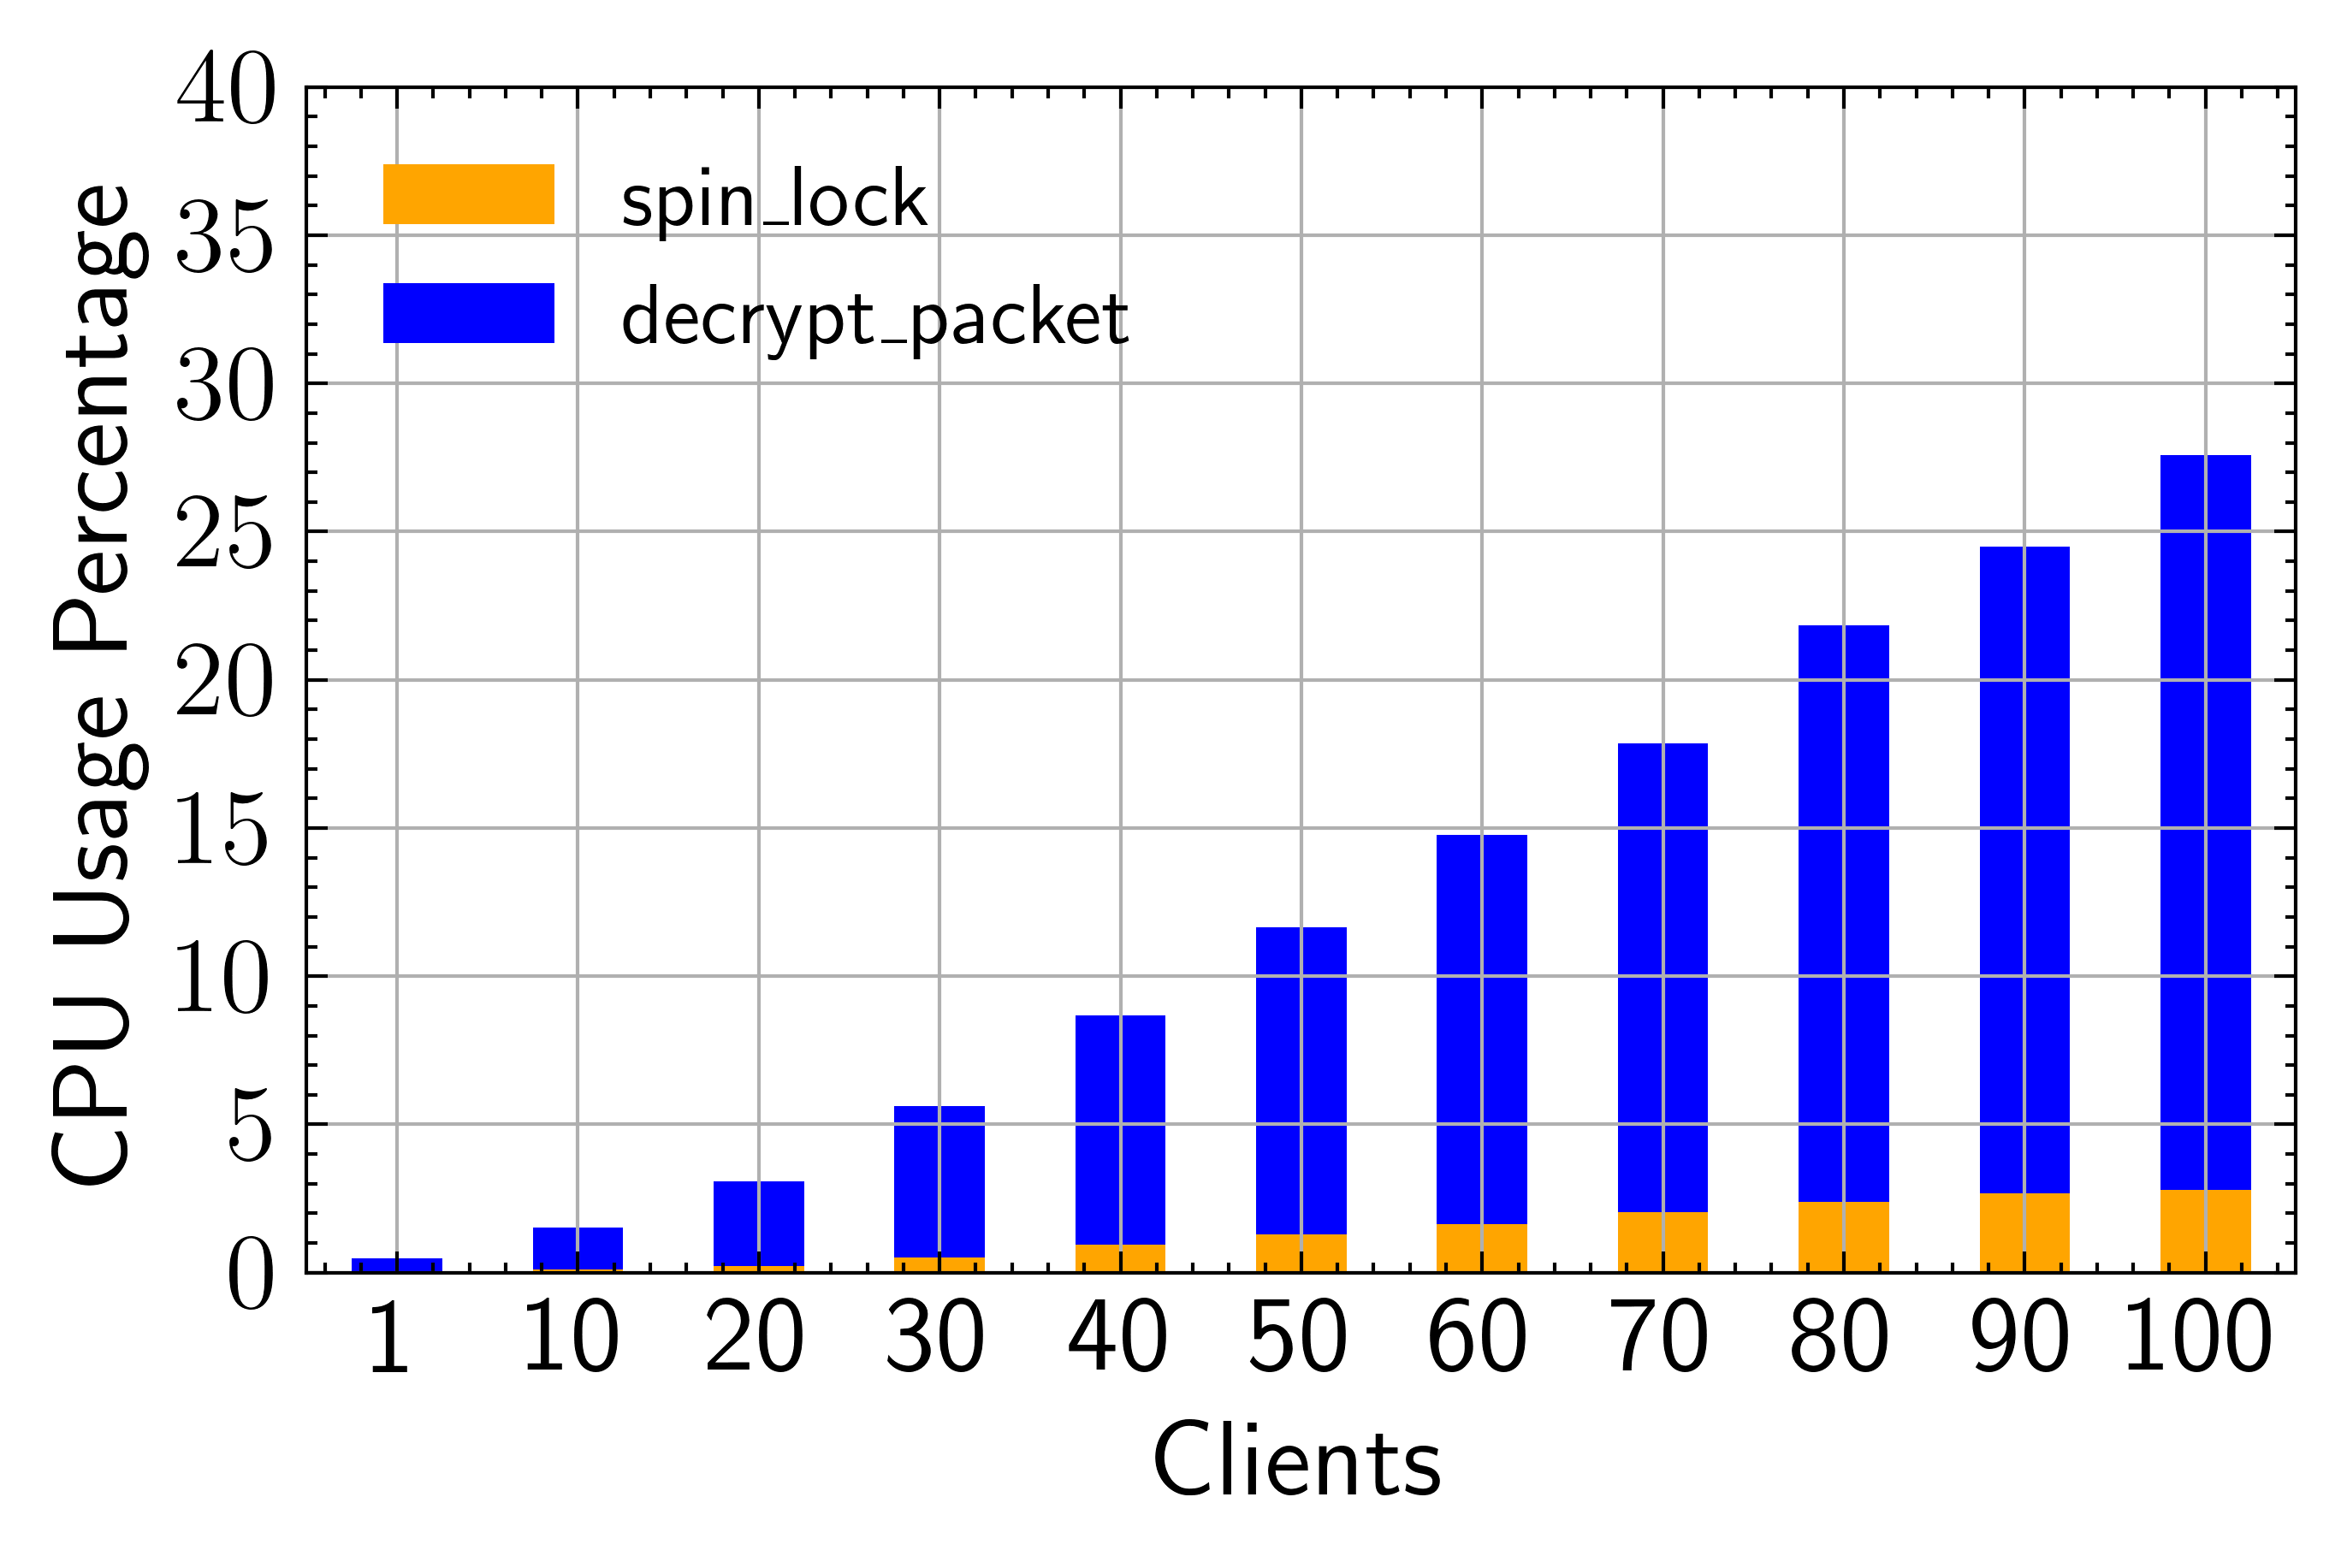

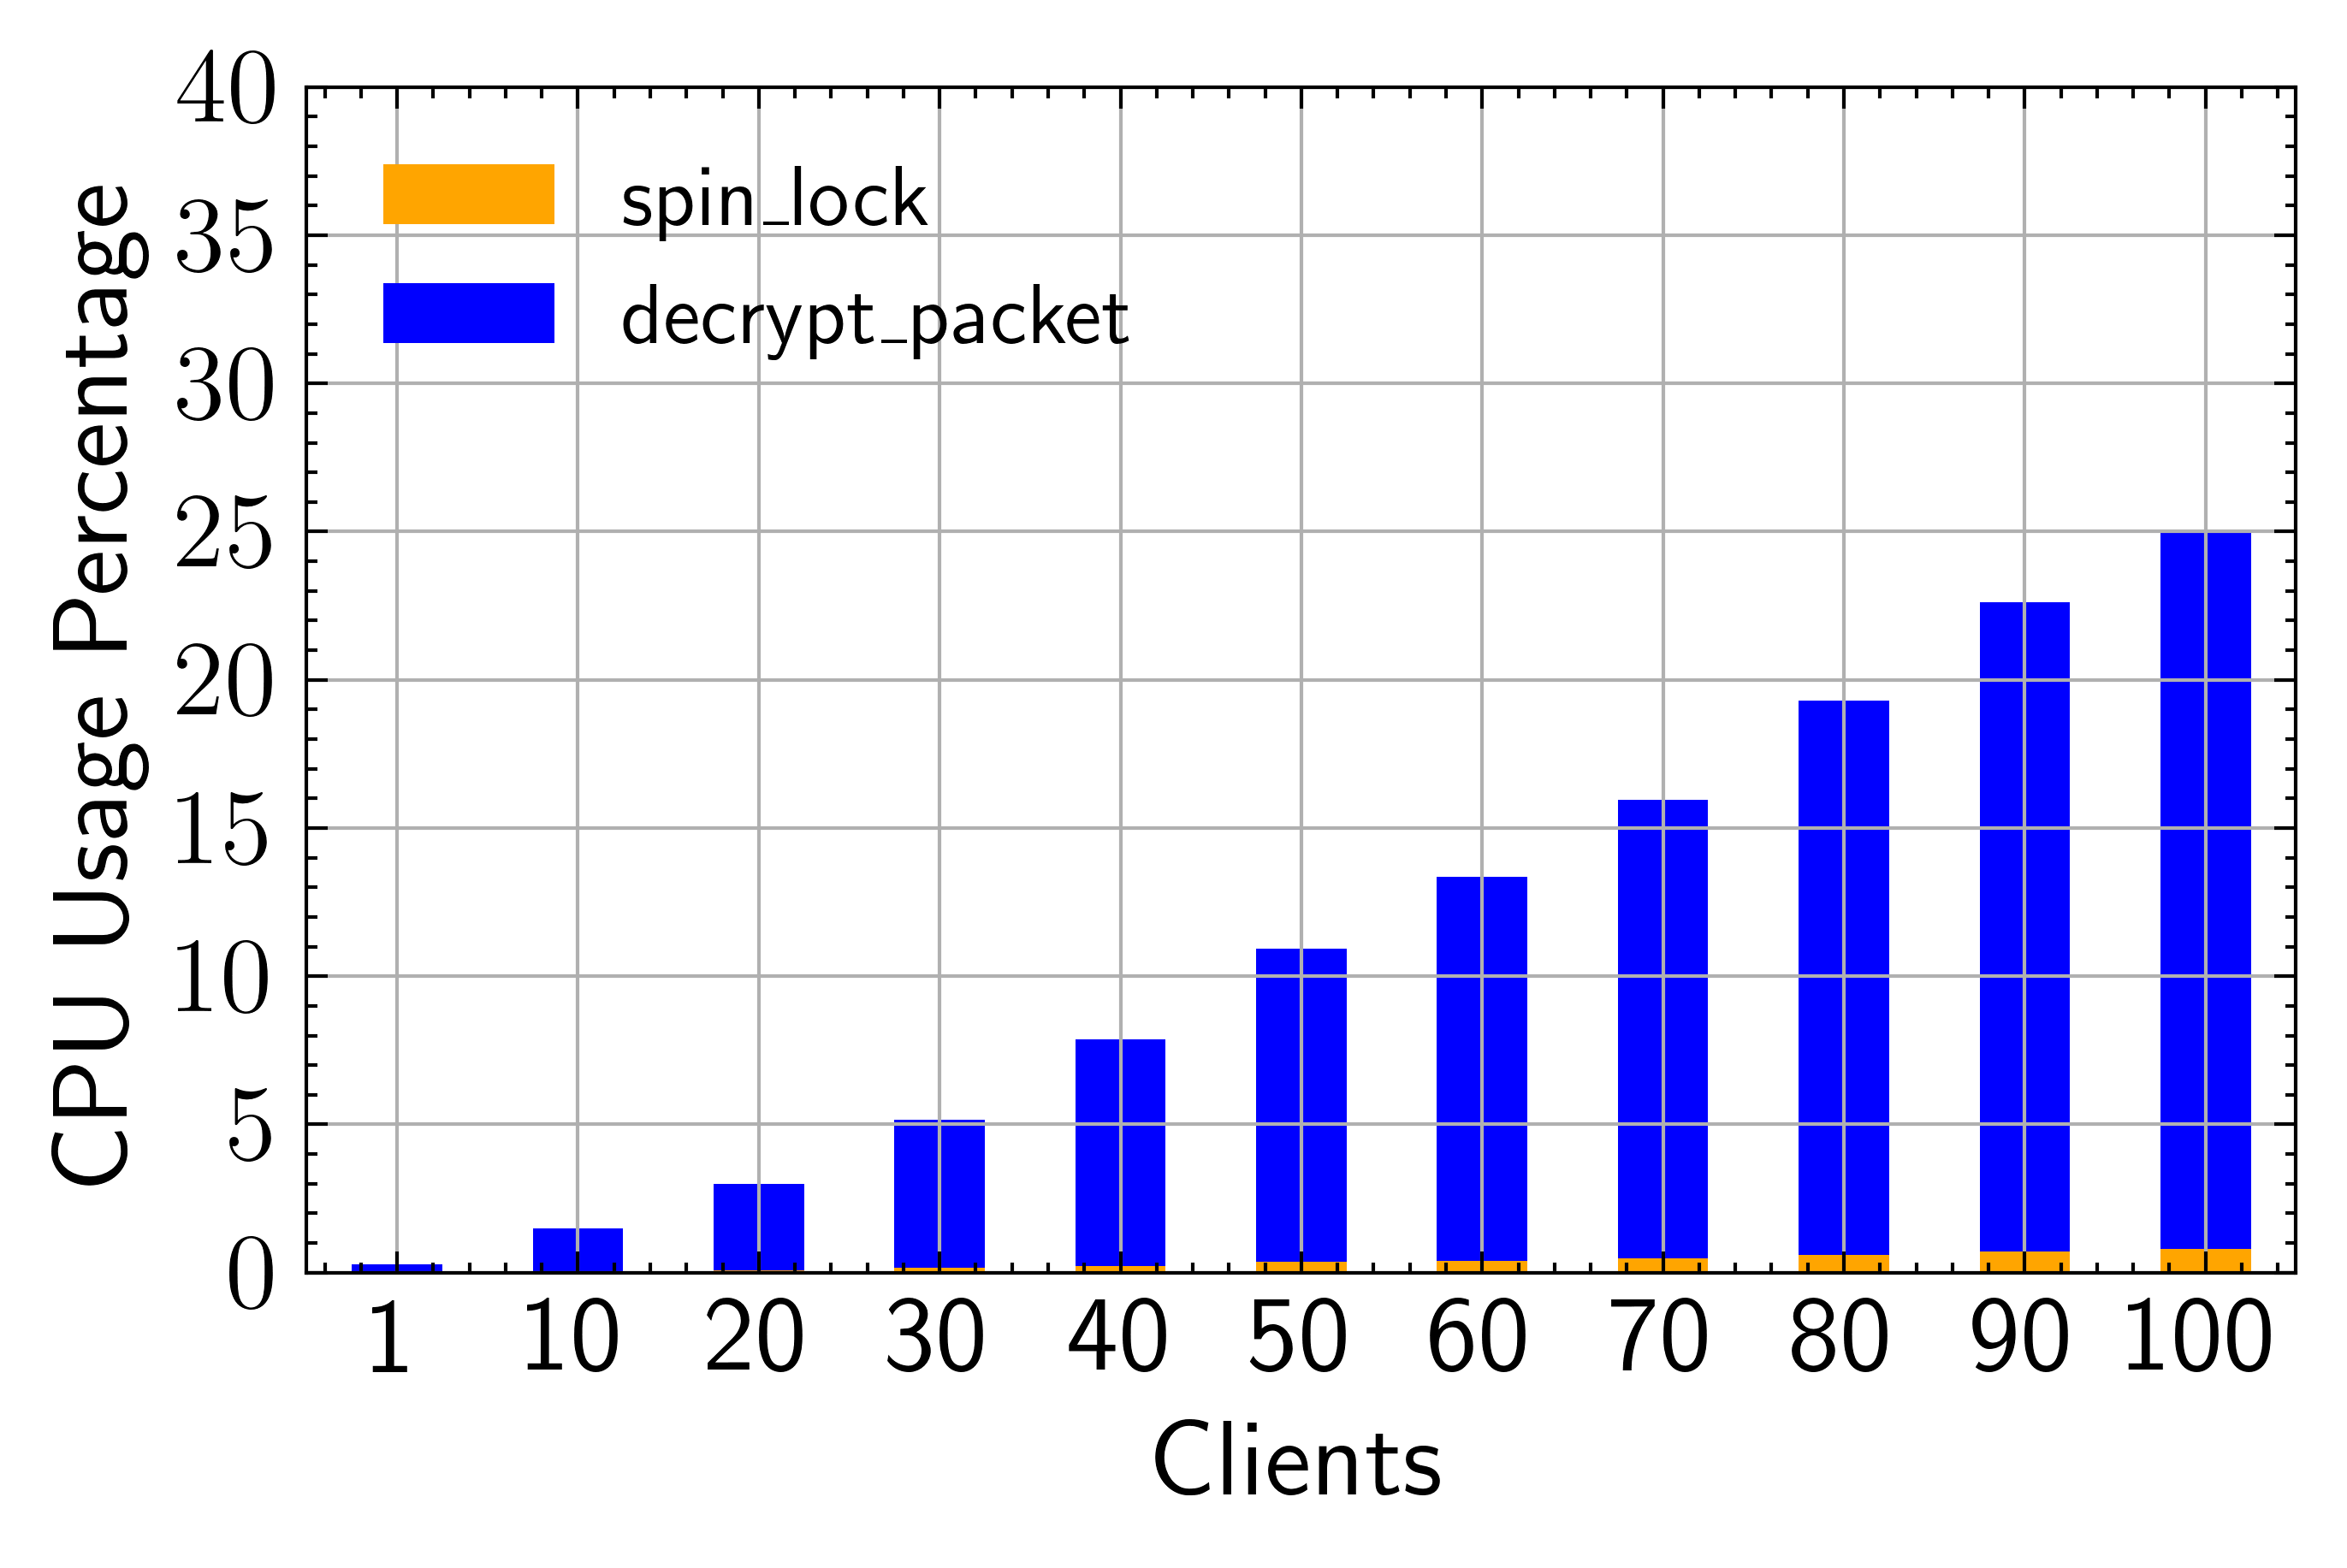

In [12]:
colors = ['black', 'red']
names=['VANILLA', 'CRYPTONCE-B10']
out = compute_improvement(res_dirs, import_decrypt_absolute, 'spin_lock', index='clients', names=names)
plot_improvement(out, ylabel="Spin lock CPU usage", annotate='improvement', names=names,
                 ylim=[0, 4], space=.2, colors=colors, n_cols=1, legend_size=8, 
#                  savefig=f"../graphs/{dir_}/decryption_cpu.pdf", 
                 fontsize=8, ticker=1,
                 figsize=(5, 3),
)
print(out)

out = compute_improvement(res_dirs, import_decrypt_absolute, 'decrypt_packet', index='clients', names=names)
plot_improvement(out, ylabel="Decryption Function CPU Usage", annotate='improvement', names=names,
                 ylim=[0, 35], space=.2, colors=colors, n_cols=1, legend_size=8, 
#                  savefig=f"../graphs/{dir_}/decryption_cpu.pdf", 
                 fontsize=8,
                 figsize=(5, 3),
)

out = compute_improvement(res_dirs, import_decrypt_absolute, 'decrypt_worker', index='clients', names=names)
plot_improvement(out, ylabel="Decryption Worker CPU Usage", annotate='improvement', names=names,
                 ylim=[0, 35], space=.2, colors=colors, n_cols=1, legend_size=8, 
#                  savefig=f"../graphs/{dir_}/decryption_cpu.pdf", 
                 fontsize=8,
                 figsize=(5, 3),
)

cols = ['spin_lock', 'decrypt_packet']
colors = ['orange', 'blue']

for res in res_dirs:
    df = import_decrypt(res['path'])[1].set_index('clients')
    with plt.style.context(['science', 'ieee']):
        ax = df[cols].plot.bar(figsize=(5, 3),
            xlabel="Clients", ylabel="CPU Usage Percentage",
            stacked=True, ylim=[0, 40], color=colors, grid=True,
        )

        plt.xticks(rotation=0)
        plt.legend(loc='upper left', prop = {"size":12})
        ax.yaxis.set_major_locator(mp.ticker.MultipleLocator(5))
        plt.savefig(f"../graphs/{dir_}/spinratios_{res['name']}.pdf", dpi=300)
# out

In [13]:
dir_ = "download-res"
skip = 1
maindir = f"../{dir_}"
res_dirs = [infos_resdir(f) for f in os.listdir(maindir)]
try:
    os.makedirs(f"../graphs/{dir_}")
except:
    pass

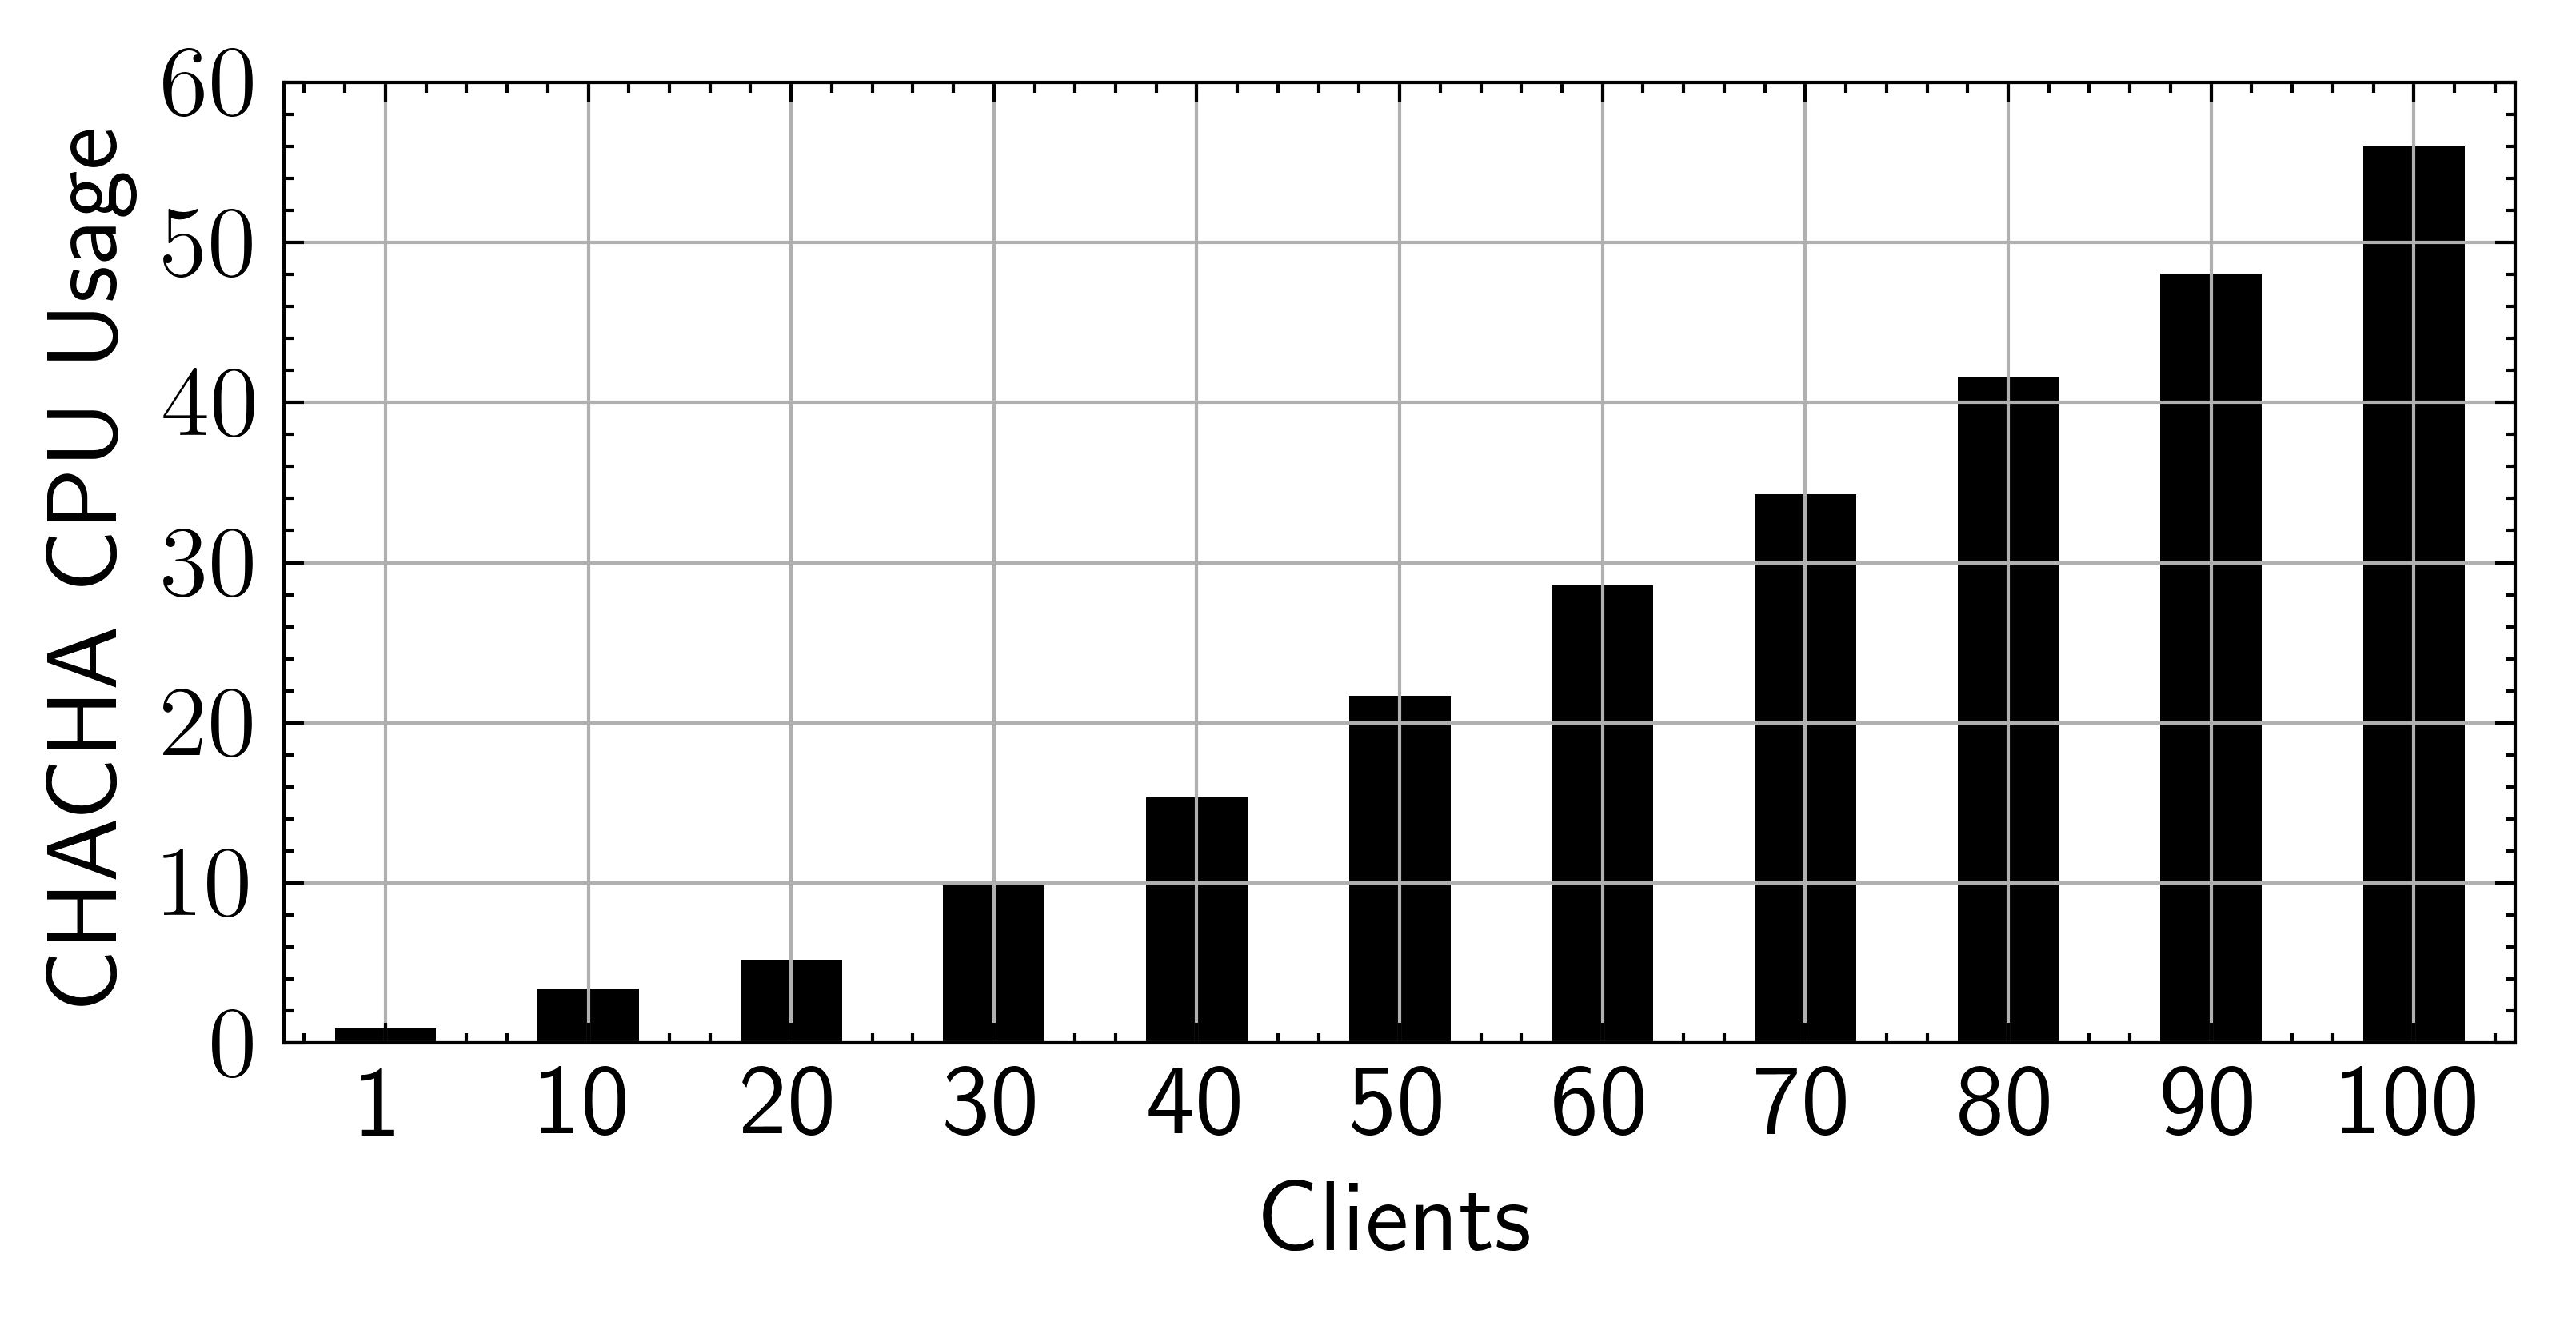

In [493]:
res_dir = res_dirs[0]
index = 'clients'
importer = import_decrypt_absolute

df = importer(res_dir['path']).reset_index(drop=True)
df = df.set_index(index)
df.loc[100, 'decrypt_packet'] = 56
cols = 'decrypt_packet'
with plt.style.context(['science', 'ieee']):
    ax = df[cols].plot.bar(
        xlabel="Clients", ylabel="CHACHA CPU Usage", ylim=[0, 60], grid=True, legend=None, figsize=(6, 2.6)
    )

    plt.xticks(rotation=0)
    ax.yaxis.set_major_locator(mp.ticker.MultipleLocator(10))
plt.savefig(f"../graphs/absolute_encryption.pdf", dpi=400)

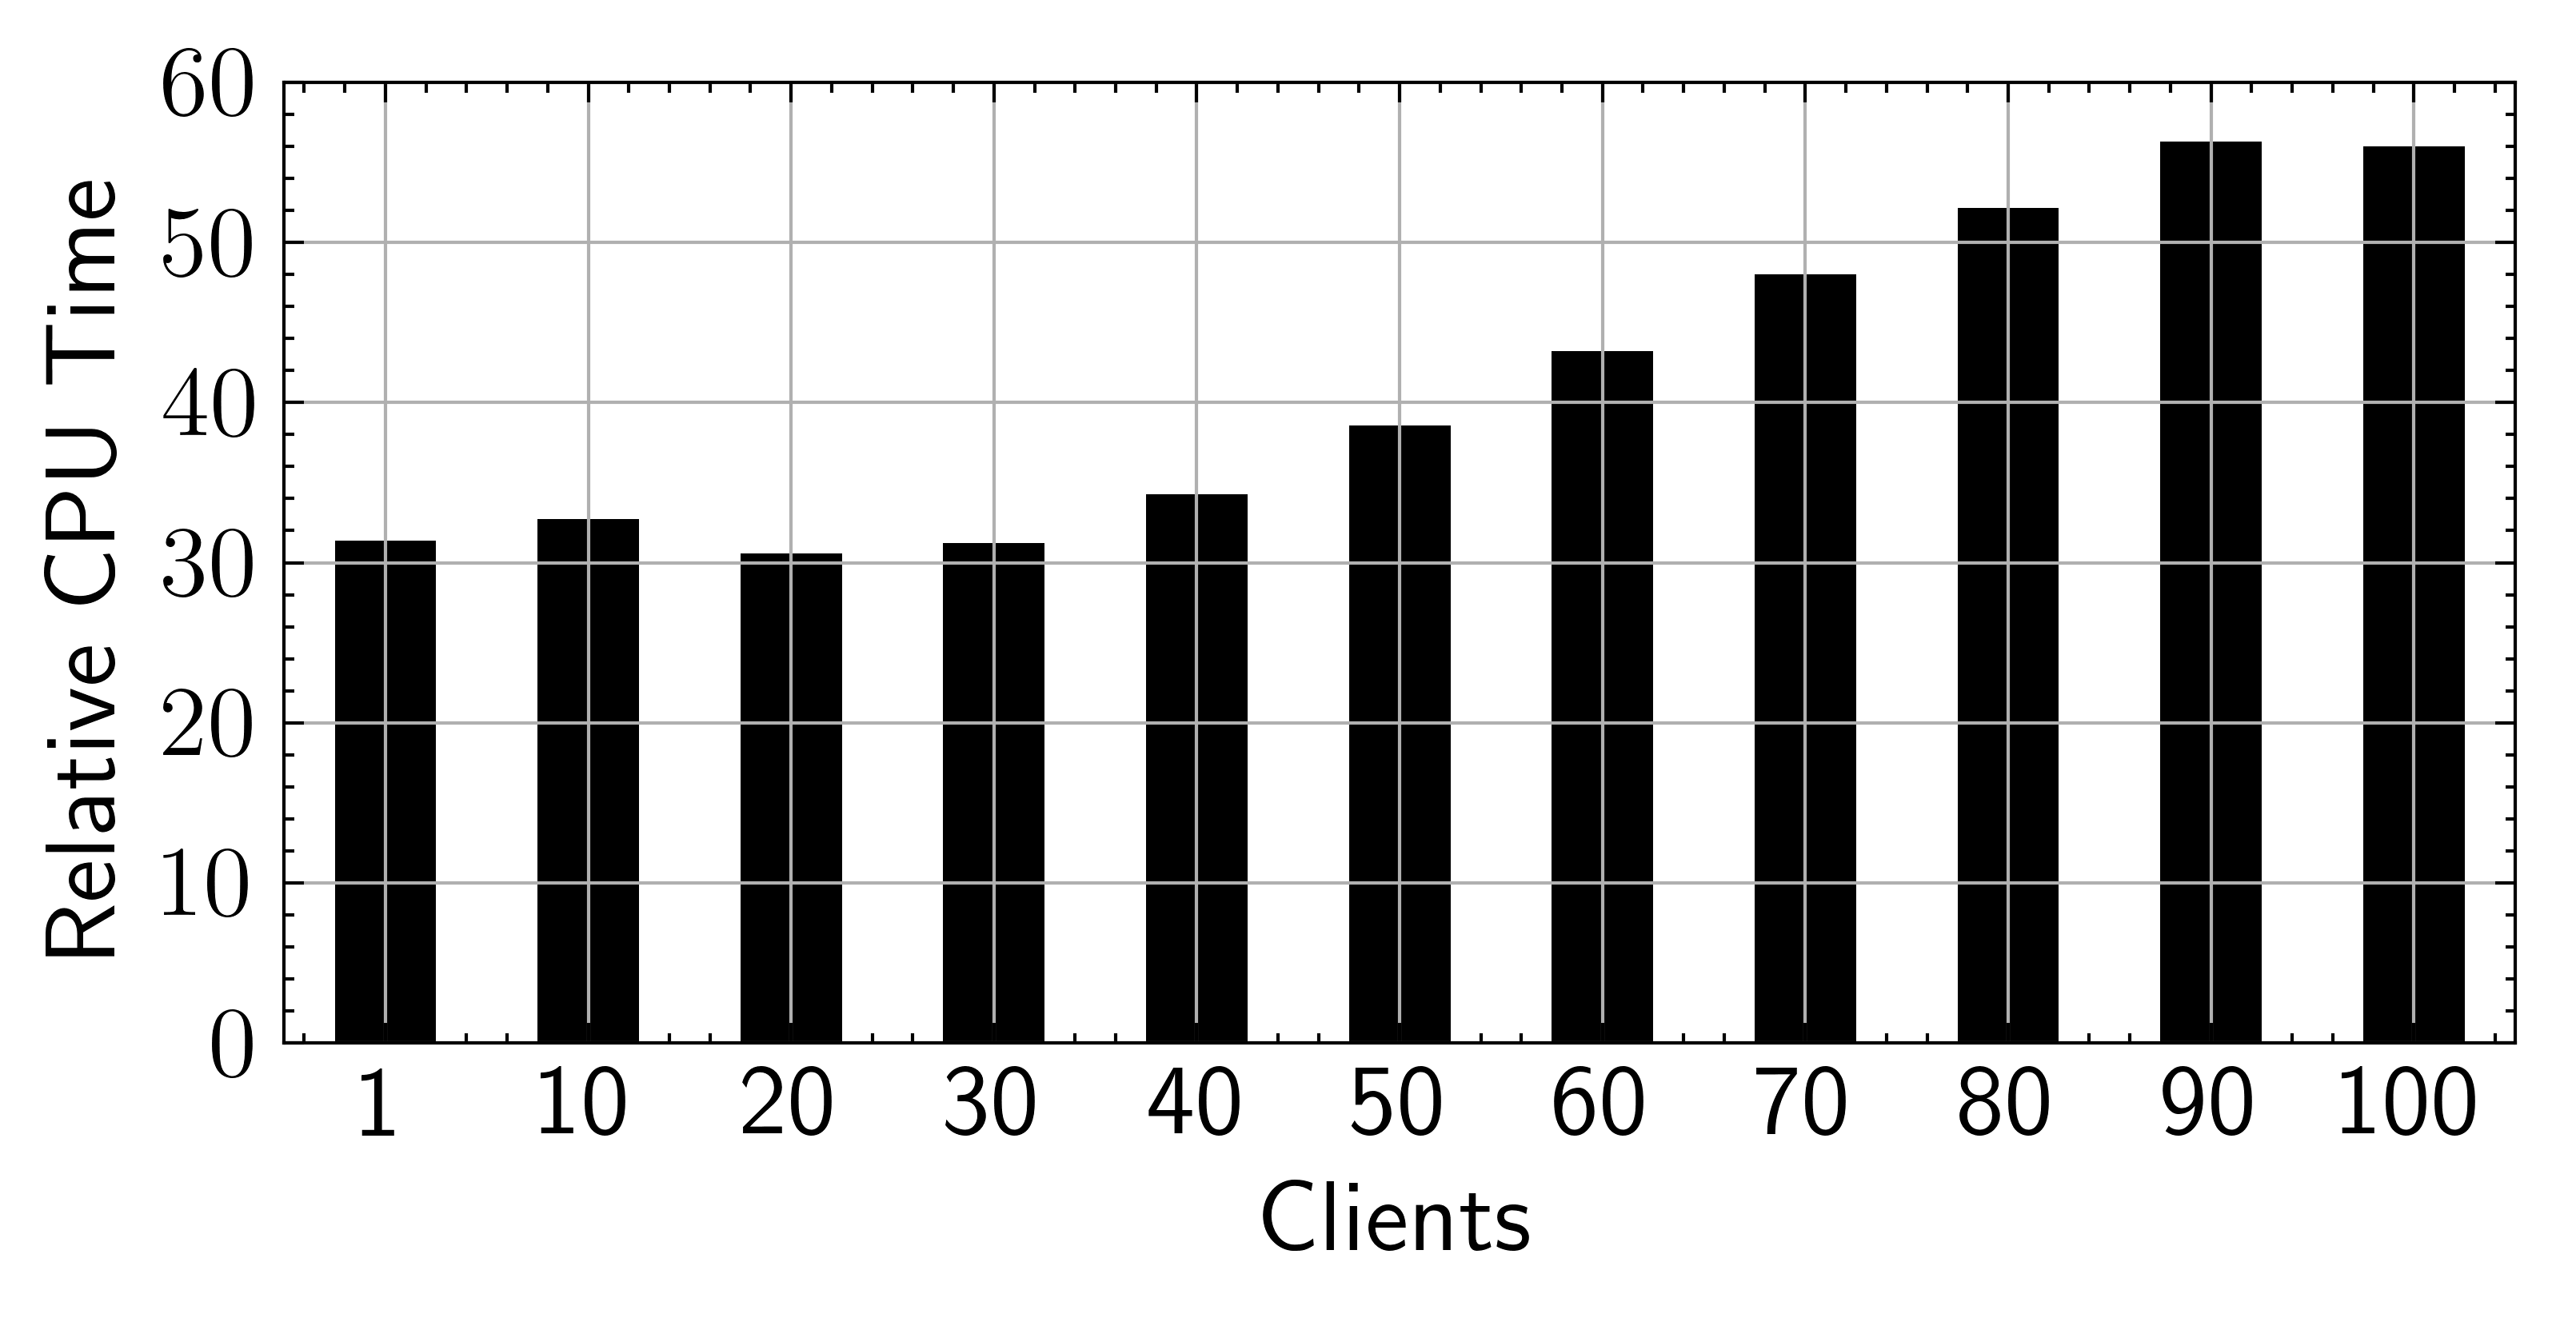

In [468]:
res_dir = res_dirs[0]
index = 'clients'
importer = import_decrypt_relative

df = importer(res_dir['path']).reset_index(drop=True)
df = df.set_index(index)
df.loc[100, 'decrypt_packet'] = 56
cols = 'decrypt_packet'
with plt.style.context(['science', 'ieee']):
    ax = df[cols].plot.bar(
        xlabel="Clients", ylabel="Relative CPU Time", ylim=[0, 60], grid=True, legend=None, figsize=(6, 2.6)
    )

    plt.xticks(rotation=0)
    ax.yaxis.set_major_locator(mp.ticker.MultipleLocator(10))
plt.savefig(f"../graphs/relative_encryption.pdf", dpi=400)

In [499]:
dir_ = "upload-res-v3-10"
skip = 1
maindir = f"../{dir_}"
res_dirs = [infos_resdir(f) for f in os.listdir(maindir)]
# index = find_index(res_dirs, 'yes')
# yes = res_dirs.pop(index)
# res_dirs.insert(0, yes)
try:
    os.makedirs(f"../graphs/{dir_}")
except:
    pass
res_dirs

[{'test': 'upload--yes-kernel-v1',
  'path': '../upload-res-v3-10/results-1b620499',
  'name': 'yes'},
 {'test': 'upload--partial-kernel-v1',
  'path': '../upload-res-v3-10/results-6cb89e7b',
  'name': 'partial'},
 {'test': 'upload--partial-kernel-v3',
  'path': '../upload-res-v3-10/results-e8055dbe',
  'name': 'partial'},
 {'test': 'upload--yes-kernel-v3',
  'path': '../upload-res-v3-10/results-6426f723',
  'name': 'yes'}]

In [500]:
res_dirs = [res_dirs[0], res_dirs[3]]

In [501]:
res_dirs

[{'test': 'upload--yes-kernel-v1',
  'path': '../upload-res-v3-10/results-1b620499',
  'name': 'yes'},
 {'test': 'upload--yes-kernel-v3',
  'path': '../upload-res-v3-10/results-6426f723',
  'name': 'yes'}]

In [502]:
colors = ['black', 'red']
out = compute_improvement(res_dirs, import_decrypt_absolute, 'decrypt_packet', index='clients')
plot_improvement(out, ylabel="Chacha CPU usage", annotate='difference',
                 ylim=[0, 30], space=1, colors=colors, n_cols=1, legend_size=12, 
                 savefig=f"../graphs/decrypt_packet_cpu.pdf", ticker=5,
                 figsize=(5, 2.6), fontsize=8
)

colors = ['black', 'red']
out = compute_improvement(res_dirs, import_decrypt_absolute, 'decrypt_worker', index='clients')
plot_improvement(out, ylabel="Decrypt Worker CPU usage", annotate='difference',
                 ylim=[0, 35], space=1, colors=colors, n_cols=1, legend_size=12, 
                 savefig=f"../graphs/decrypt_worker_cpu.pdf", ticker=5,
                 figsize=(5, 2.6), fontsize=8
)

colors = ['black', 'red']
out = compute_improvement(res_dirs, import_decrypt_absolute, 'spin_lock', index='clients')
plot_improvement(out, ylabel="Spin Lock CPU usage", annotate='difference',
                 ylim=[0, 15], space=1, colors=colors, n_cols=1, legend_size=12, 
                 savefig=f"../graphs/spinlock_cpu.pdf", ticker=5,
                 figsize=(5, 2.6), fontsize=8
)

cols = ['spin_lock', 'decrypt_packet']
cols_1 = ['decrypt_worker']
colors = ['orange', 'blue']

skip = 1

for res in res_dirs:
    df = import_decrypt(res['path'])[1]
    df = df[df['clients'] != skip]
    df.set_index('clients', inplace=True)
    print(res['name'])
    print(df)
    print()

#     with plt.style.context(['science', 'ieee']):
#         ax = df[cols_1].plot.bar(
#             xlabel="Clients", ylabel="CPU Usage Percentage",
#             stacked=True, ylim=[0, 42], color=['green'], grid=True, figsize=(4.7, 2.6),
#         )

#         plt.xticks(rotation=0)
#         plt.legend(loc='upper left', prop = {"size":12})
#         ax.yaxis.set_major_locator(mp.ticker.MultipleLocator(5))
#         plt.savefig(f"../graphs/worker_{res['name']}.pdf", dpi=300)
    
    with plt.style.context(['science', 'ieee']):
        ax = df[cols].plot.bar(
            xlabel="Clients", ylabel="CPU Usage Percentage",
            stacked=True, ylim=[0, 42], color=colors, grid=True, figsize=(5, 3),
        )

        plt.xticks(rotation=0)
        plt.legend(loc='upper left', prop = {"size":12})
        ax.yaxis.set_major_locator(mp.ticker.MultipleLocator(5))
        plt.savefig(f"../graphs/spinratios_{res['name']}.pdf", dpi=300)
print(out)

KeyError: "['CRYPTONCE'] not in index"